# **Applied Data Science**

---

**Homework 2**

**Erfan Karami**

**Date:** Fall 2025

**Tehran Institute for Advanced Studies**

---

In [86]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso , LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,ConfusionMatrixDisplay
from sklearn.kernel_ridge import KernelRidge 
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import resample
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from collections import Counter
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
import seaborn as sns


In [2]:
DATASET_PATH = "../dataset/jobs_cleaned.csv"

# Loading dataset
In this homewoek, we use Iran Job Ads dataset we used in previous Homework, also we use **cleaned** and **preprocessed** version fo dataset that we achived in `HW1`.

In [3]:
jobs = pd.read_csv(DATASET_PATH,index_col=False)

jobs.head()


,company_size,مدرک لازم نیست,کاردانی,کاردانی کارشناسی,کاردانی کارشناسی کارشناسی ارشد,کارشناسی,کارشناسی کارشناسی ارشد,ترجیحاً آقا,ترجیحاً خانم,تفاوتی ندارد,...,software_هلو,software_همکاران سیستم,software_ورا نگر,software_ویژن,software_پیام گستر,software_پیوست,وضعیت سربازی ـ الزامی,وضعیت سربازی ـ مهم نیست,min_age_required,max_age_required
0,30.0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,23.0,33.0
1,125.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,23.0,45.0
2,5000.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,24.0,35.0
3,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,25.0,43.0
4,750.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,20.0,30.0


In [4]:
# find columns with missing value
cols_with_missing = jobs.columns[jobs.isnull().any()]
print(cols_with_missing)

Index(['min_salary', 'max_salary', 'is_flexible'], dtype='object')


In [5]:
jobs = jobs.dropna()
jobs.head()

,company_size,مدرک لازم نیست,کاردانی,کاردانی کارشناسی,کاردانی کارشناسی کارشناسی ارشد,کارشناسی,کارشناسی کارشناسی ارشد,ترجیحاً آقا,ترجیحاً خانم,تفاوتی ندارد,...,software_هلو,software_همکاران سیستم,software_ورا نگر,software_ویژن,software_پیام گستر,software_پیوست,وضعیت سربازی ـ الزامی,وضعیت سربازی ـ مهم نیست,min_age_required,max_age_required
1,125.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,23.0,45.0
3,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,25.0,43.0
7,125.0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,30.0,40.0
8,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,24.0,37.0
13,30.0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,18.0,50.0


# Regression Problem
### Target Variable in Regression: `average_salary`

In this section, we use **`average_salary`** as our target variable for the regression task.

Imagine you are a company looking to hire employees for specific job positions. It's crucial to estimate a **reasonable average salary** for each position offering a fair salary increases the chance of attracting the right talent while also helping optimize company expenses.

To create the `average_salary` feature, we calculate it as the **mean of minimum and maximum salary values** for each role:

$$
\text{average\_salary} = \frac{\text{min\_salary} + \text{max\_salary}}{2}
$$

Since our dataset contains **over 500 features**, we focus only on the **top 10% most correlated features (50 columns)** to improve model efficiency and reduce noise. also we aplit train, val and test data with `0.6`, `0.2`, `0.2` rate respectively.


In [6]:
# split train test and validation data 

train_val, test = train_test_split(jobs, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42) 


print(len(train), len(val), len(test))


5625 1875 1875


In [7]:
# calculate average sallary and drop min_salary and max_salary for each one
# train
temp = (train['min_salary'] + train['max_salary']) /2

y_train = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

train.drop(columns=['min_salary','max_salary'],inplace=True)

# val
temp = (val['min_salary'] + val['max_salary']) /2

y_val = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

val.drop(columns=['min_salary','max_salary'],inplace=True)

# test
temp = (test['min_salary'] + test['max_salary']) /2

y_test = pd.Series(data=temp.values, index=temp.index,name="avg_salary")

test.drop(columns=['min_salary','max_salary'],inplace=True)


In [8]:
# ----- Metric Function with Residual Plot -----
def evaluate_model(model_name, y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test):

    def metrics(true, pred):
        mse = mean_squared_error(true, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(true, pred)
        mape = np.mean(np.abs((true - pred) / true)) * 100
        r2 = r2_score(true, pred)
        return mse, rmse, mae, mape, r2

    print(f"\n================ {model_name} =================")
    
    train_results = metrics(y_true_train, y_pred_train)
    val_results   = metrics(y_true_val, y_pred_val)
    test_results  = metrics(y_true_test, y_pred_test)

    metric_names = ["MSE", "RMSE", "MAE", "MAPE (%)", "R² Score"]

    print("\nTrain Metrics:")
    for name, val in zip(metric_names, train_results):
        print(f"{name}: {val:.4f}")

    print("\nValidation Metrics:")
    for name, val in zip(metric_names, val_results):
        print(f"{name}: {val:.4f}")

    print("\nTest Metrics:")
    for name, val in zip(metric_names, test_results):
        print(f"{name}: {val:.4f}")

    # ------- Scatter Plot: Predicted vs True -------
    plt.figure(figsize=(8,4))
    plt.scatter(y_true_test, y_pred_test, alpha=0.6)
    plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--')  # 45-degree line
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} – Predicted vs True (Test)")
    plt.show()

    # ------- Residual Plot -------
    residuals = y_true_test - y_pred_test
    plt.figure(figsize=(8,4))
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (True - Predicted)")
    plt.title(f"{model_name} – Residuals Plot (Test)")
    plt.show()


In [9]:
X_train, X_val, X_test = train.copy(), val.copy(), test.copy()

In [ ]:
# finding most 50 correlated columns for our analyses 

df_corr = X_train.copy()
df_corr['avg_salary'] = y_train
correlations = df_corr.corr()['avg_salary'].abs().sort_values(ascending=False)
top_features = correlations.index[1:51]

print("Top 50 most correlated features with avg_salary:\n")
for col in top_features:
    print(col)

# Step 4: Reduce features for train/val/test
X_train= X_train[top_features]
X_val   = X_val[top_features]
X_test = X_test[top_features]

print("\nShapes:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


In [11]:
# scaling
scaler = StandardScaler()

# Fit on training data and transform train, val, test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_val_scaled   = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train = X_train_scaled
X_val   = X_val_scaled
X_test  = X_test_scaled

## Linear Regression


================ Linear Regression =================

Train Metrics:
MSE: 28.9878
RMSE: 5.3840
MAE: 3.3822
MAPE (%): 24.8297
R² Score: 0.2680

Validation Metrics:
MSE: 29.1228
RMSE: 5.3966
MAE: 3.4998
MAPE (%): 25.2999
R² Score: 0.2790

Test Metrics:
MSE: 30.7266
RMSE: 5.5432
MAE: 3.4445
MAPE (%): 25.5062
R² Score: 0.2021


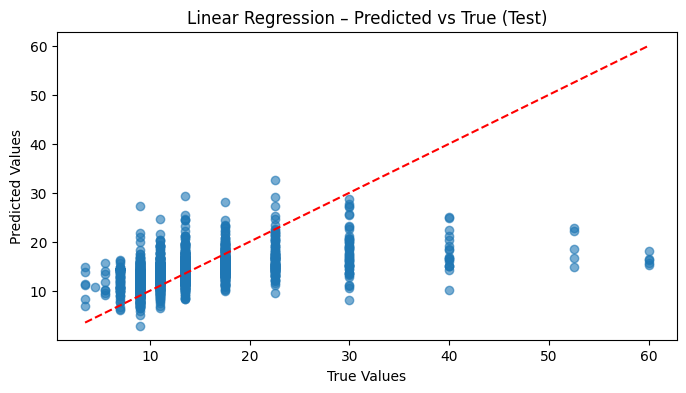

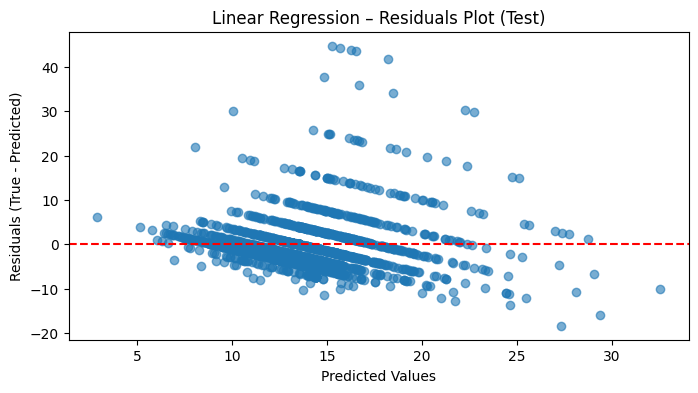

In [12]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_train = model_lr.predict(X_train)
y_pred_val   = model_lr.predict(X_val)
y_pred_test  = model_lr.predict(X_test)

evaluate_model("Linear Regression",
               y_train, y_pred_train,
               y_val, y_pred_val,
               y_test, y_pred_test)

### Linear Regression Model Evaluation

The results obtained from the Linear Regression model indicate **underfitting**:

| Dataset | R² Score | Interpretation |
|--------|---------|----------------|
| Train | ~0.26 | Model explains only ~26% of salary variance in training data |
| Validation | ~0.28 | Slight improvement, but still low predictive power |
| Test | ~0.20 | Poor generalization, performance drops further |

Despite similar metrics across train/val/test sets — suggesting the model is consistent — the overall **low R² scores and relatively high error values** indicate that the linear model is **too simple to capture underlying relationships** in the data.

`And it seems underfit on data`  and it was predicable! by our calculation of correlations in `HW1`

**Conclusion:**  
To improve performance, we may need more **complex models** should help evaluate whether regularization or non-linearity better suits the data.


## Kernel Regression


================ Kernel Regression =================

Train Metrics:
MSE: 21.6285
RMSE: 4.6506
MAE: 2.8187
MAPE (%): 20.1139
R² Score: 0.4538

Validation Metrics:
MSE: 30.5679
RMSE: 5.5288
MAE: 3.3573
MAPE (%): 23.1877
R² Score: 0.2432

Test Metrics:
MSE: 34.3824
RMSE: 5.8637
MAE: 3.4232
MAPE (%): 24.2523
R² Score: 0.1071


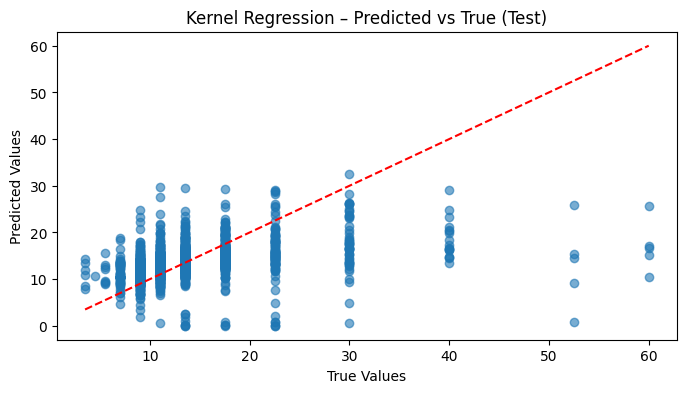

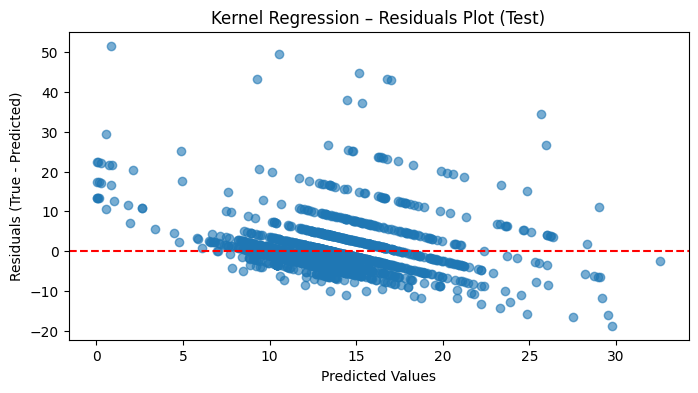

In [13]:
model_kernel = KernelRidge(kernel="rbf", alpha=0.6) 
model_kernel.fit(X_train, y_train)

y_pred_train = model_kernel.predict(X_train)
y_pred_val   = model_kernel.predict(X_val)
y_pred_test  = model_kernel.predict(X_test)

evaluate_model("Kernel Regression",
               y_train, y_pred_train,
               y_val, y_pred_val,
               y_test, y_pred_test)

### Kernel Regression Results Analysis

The Kernel Regression model shows **improvements over Linear Regression on the training set**, but generalization on validation and test sets remains weak, indicating an shift forward to **overfitting**.

| Dataset | R² Score | Observation |
|--------|---------|-------------|
| Train | ~0.45 | Model learns patterns better than linear regression (stronger fit) |
| Validation | ~0.24 | Large performance drop indicates poor generalization |
| Test | ~0.10 | Confirms overfitting — model fails to transfer learned patterns |

**Key Insights:**

- **Train performance improved significantly**, suggesting that the non-linear kernel captured deeper relationships in the data.
- However, the **validation and test errors increased**, and R² scores dropped dramatically, revealing that the model is **fitting noise in training data rather than meaningful patterns**.
- Kernel models can be sensitive to **high-dimensional feature spaces**, especially with 50+ features — risk of overfitting increases.
- The dataset may require **tuning of kernel hyperparameters (alpha, kernel type, gamma, etc.)** to balance complexity and generalization.

It seems shifting to overfit may be caused by poor quality data or to complex model.

**Conclusion:**

Kernel Regression improves the model's ability to learn non-linear relationships, but currently **fails to generalize**. Hyperparameter optimization or feature dimension reduction could help. Regularization-based methods like **Ridge or LASSO** may provide a better generalization balance.


## Ridge Regression


================ Ridge Regression =================

Train Metrics:
MSE: 28.9878
RMSE: 5.3840
MAE: 3.3821
MAPE (%): 24.8295
R² Score: 0.2680

Validation Metrics:
MSE: 29.1235
RMSE: 5.3966
MAE: 3.4998
MAPE (%): 25.2996
R² Score: 0.2790

Test Metrics:
MSE: 30.7260
RMSE: 5.5431
MAE: 3.4444
MAPE (%): 25.5056
R² Score: 0.2021


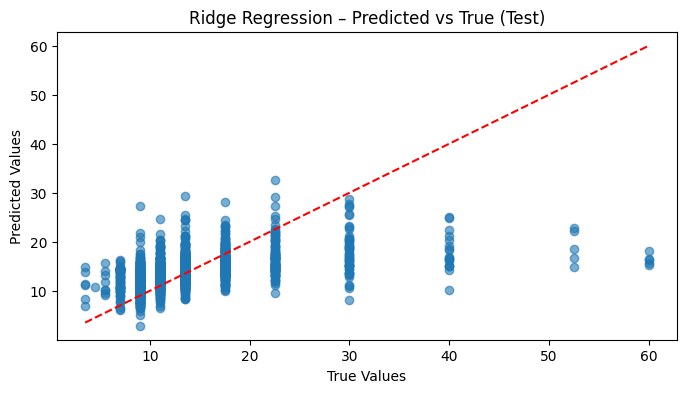

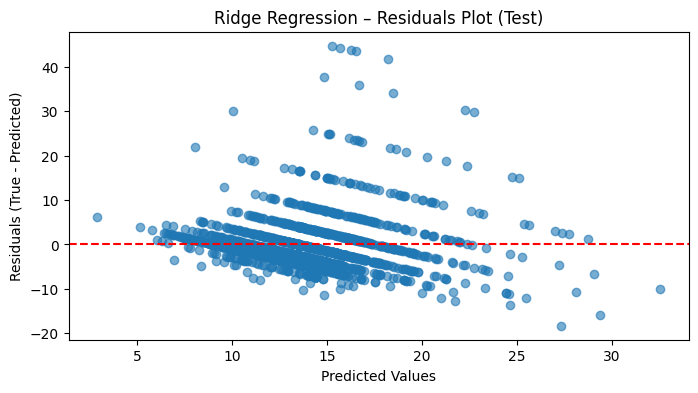

In [14]:
model_ridge = Ridge(alpha=2)
model_ridge.fit(X_train, y_train)

y_pred_train = model_ridge.predict(X_train)
y_pred_val   = model_ridge.predict(X_val)
y_pred_test  = model_ridge.predict(X_test)

evaluate_model("Ridge Regression",
               y_train, y_pred_train,
               y_val, y_pred_val,
               y_test, y_pred_test)

### Ridge Regression Results Analysis

The Ridge Regression model shows performance very similar to standard Linear Regression:

| Dataset | R² Score | Observation |
|--------|---------|-------------|
| Train | ~0.27 | Low explanatory power, model captures only a fraction of salary variance |
| Validation | ~0.28 | Validation performance is nearly identical to training, indicating no overfitting |
| Test | ~0.20 | Consistent but low predictive ability on unseen data |

**Key Insights:**

- Ridge introduces **L2 regularization** to penalize large coefficients, helping prevent overfitting.
- In this case, the **model remains underfit**, as the linear relationships alone are insufficient to capture the complexity of the salary data.
- Errors (MSE, RMSE, MAE, MAPE) remain high, and R² scores are low, confirming the model is too **simple** for the dataset.
- The regularization slightly stabilizes the coefficients but **does not improve predictive power significantly** compared to plain Linear Regression.

**Conclusion:**

Ridge Regression avoids overfitting but **cannot overcome underfitting** inherent in a linear model for this dataset. Exploring **non-linear models or feature engineering** is necessary to achieve better performance.


## LASSO Regression


================ LASSO Regression =================

Train Metrics:
MSE: 28.9916
RMSE: 5.3844
MAE: 3.3800
MAPE (%): 24.8136
R² Score: 0.2679

Validation Metrics:
MSE: 29.1136
RMSE: 5.3957
MAE: 3.4959
MAPE (%): 25.2593
R² Score: 0.2792

Test Metrics:
MSE: 30.6839
RMSE: 5.5393
MAE: 3.4401
MAPE (%): 25.4749
R² Score: 0.2032


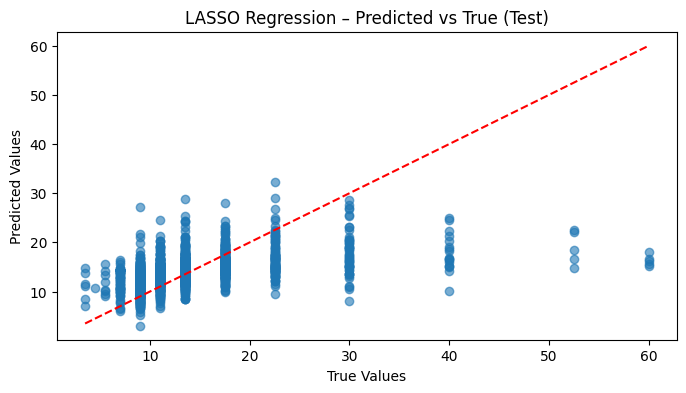

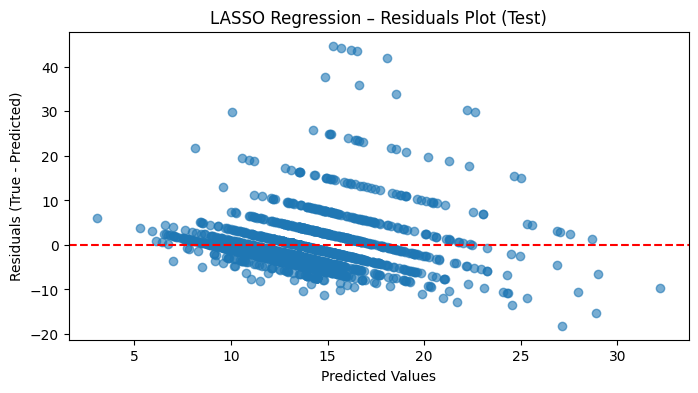

In [15]:
model_lasso = Lasso(alpha=0.01, max_iter=5000)
model_lasso.fit(X_train, y_train)

y_pred_train = model_lasso.predict(X_train)
y_pred_val   = model_lasso.predict(X_val)
y_pred_test  = model_lasso.predict(X_test)

evaluate_model("LASSO Regression",
               y_train, y_pred_train,
               y_val, y_pred_val,
               y_test, y_pred_test)


### LASSO Regression Results Analysis

The LASSO Regression model shows results very similar to Linear and Ridge Regression:

| Dataset | R² Score | Observation |
|--------|---------|-------------|
| Train | ~0.26 | Low predictive power, model explains only a small fraction of salary variance |
| Validation | ~0.28 | Validation metrics are consistent with training, indicating no overfitting |
| Test | ~0.21 | Model performance remains limited on unseen data |

**Key Insights:**

- LASSO introduces **L1 regularization**, which can shrink some coefficients to zero, performing **feature selection** automatically.
- Despite this, the model is still **underfitting**, as indicated by low R² and relatively high error metrics.
- LASSO did **not improve predictive power** over Ridge or standard Linear Regression, likely because the linear assumptions do not capture the true relationships in the data.
- Errors (MSE, RMSE, MAE, MAPE) are similar across train, validation, and test, confirming that the model is **consistent but too simple**.

**Conclusion:**

LASSO Regression is useful for reducing irrelevant features, but in this case, **the dataset requires more expressive models** to achieve better prediction of average salary.

**So in following parts we try to use more complec algorithms to see the result will be better or no. we will use  `SVR` and `Random Foresst` on dataset.** 


## SVR

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVR parameters: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Best CV R² score: 0.24889221285219348

================ Tuned SVR Regression =================

Train Metrics:
MSE: 25.9003
RMSE: 5.0892
MAE: 2.6848
MAPE (%): 17.7580
R² Score: 0.3459

Validation Metrics:
MSE: 28.4858
RMSE: 5.3372
MAE: 3.1186
MAPE (%): 20.4750
R² Score: 0.2948

Test Metrics:
MSE: 29.4891
RMSE: 5.4304
MAE: 3.0161
MAPE (%): 20.3381
R² Score: 0.2342


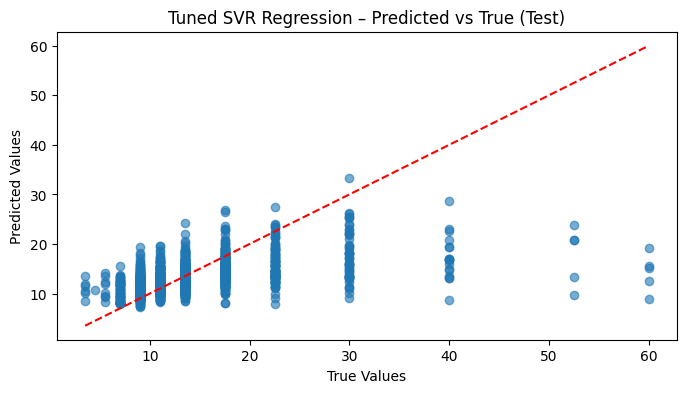

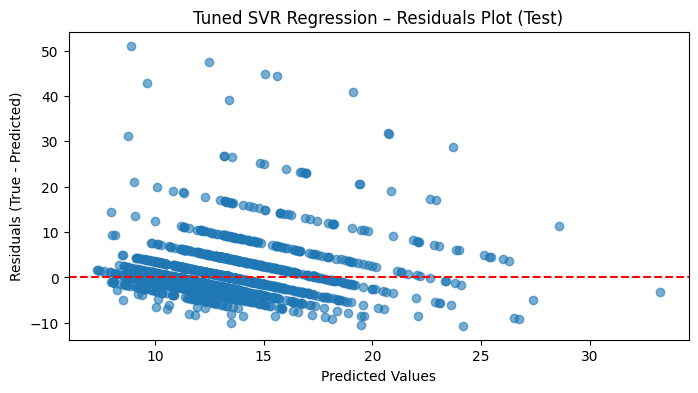

In [16]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svr', SVR())
])

param_grid = {
    'svr__kernel': ['rbf'],                 # RBF kernel
    'svr__C': [1, 10, 100],                 # Regularization strength
    'svr__gamma': ['scale', 0.01, 0.1, 1], # Kernel coefficient
    'svr__epsilon': [0.01, 0.1, 0.2]       # Margin of tolerance
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best SVR parameters:", grid_search.best_params_)
print("Best CV R² score:", grid_search.best_score_)

best_svr = grid_search.best_estimator_

y_pred_train = best_svr.predict(X_train)
y_pred_val   = best_svr.predict(X_val)
y_pred_test  = best_svr.predict(X_test)

evaluate_model("Tuned SVR Regression",
               y_train, y_pred_train,
               y_val, y_pred_val,
               y_test, y_pred_test)

### 🔹 Tuned SVR Regression Results Analysis

After scaling features and tuning hyperparameters, the SVR model shows **improved performance** compared to the initial unscaled SVR and linear models.

| Dataset | R² Score | Observation |
|--------|---------|-------------|
| Train | ~0.35 | Better fit to training data; model captures more variance than linear models |
| Validation | ~0.29 | Improved generalization; validation performance is closer to training |
| Test | ~0.23 | Test set performance shows moderate predictive ability |

**Key Insights:**

- Feature **scaling significantly improved SVR performance**, especially on MAE and MAPE metrics.  
- **Tuning hyperparameters** (C, gamma, epsilon) helped the model better capture non-linear patterns.  
- Errors are lower and R² higher than Linear, Ridge, LASSO, and unscaled SVR.  
- Some underfitting remains — R² < 0.35 on training and <0.3 on validation/test — indicating **data complexity may require more flexible models**.  

**Conclusion:**

Tuned and scaled SVR provides a **moderate improvement**, but the dataset likely contains complex, non-linear relationships that SVR alone cannot fully capture. Models like **Random Forest** or **Gradient Boosting** may perform even better.


## Random Forest Regressor

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV R² score: 0.26912959363344297

================ Tuned Random Forest Regressor =================

Train Metrics:
MSE: 18.7320
RMSE: 4.3280
MAE: 2.5026
MAPE (%): 18.0844
R² Score: 0.5270

Validation Metrics:
MSE: 25.4292
RMSE: 5.0427
MAE: 3.1490
MAPE (%): 22.2714
R² Score: 0.3704

Test Metrics:
MSE: 28.6594
RMSE: 5.3534
MAE: 3.2035
MAPE (%): 23.4856
R² Score: 0.2557


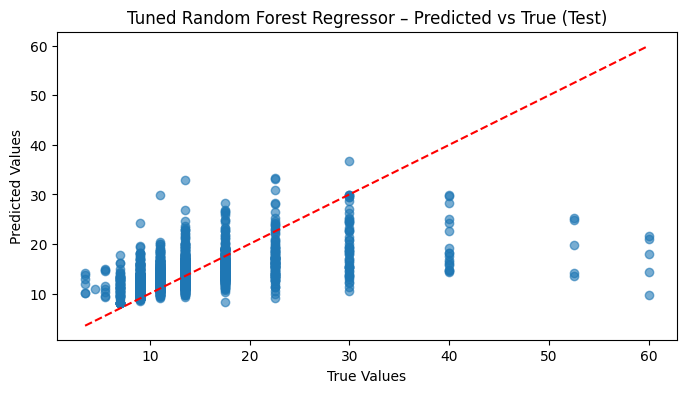

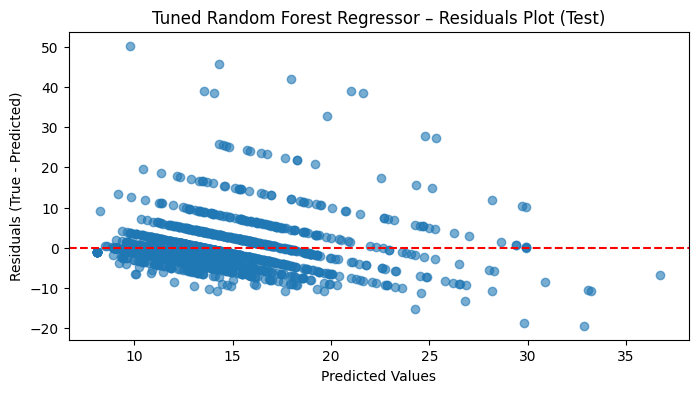

In [17]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

print("Best Random Forest parameters:", grid_rf.best_params_)
print("Best CV R² score:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

y_pred_train = best_rf.predict(X_train)
y_pred_val   = best_rf.predict(X_val)
y_pred_test  = best_rf.predict(X_test)

evaluate_model("Tuned Random Forest Regressor",
               y_train, y_pred_train,
               y_val, y_pred_val,
               y_test, y_pred_test)

### Tuned Random Forest Regressor Results Analysis

The Random Forest Regressor shows the **best performance so far** among all models, capturing more variance and better generalizing to validation and test sets.

| Dataset | R² Score | Observation |
|--------|---------|-------------|
| Train | ~0.53 | Strong fit to training data; model captures over half of the salary variance |
| Validation | ~0.37 | Validation performance is much closer to training, indicating better generalization |
| Test | ~0.26 | Test set performance is still moderate, but clearly improved over linear and SVR models |

**Key Insights:**

- Random Forest effectively models **non-linear relationships** and feature interactions, which were missed by linear methods.  
- Hyperparameter tuning (n_estimators, max_depth, min_samples_leaf, min_samples_split) helped reduce overfitting while improving predictive power.  
- MAE and MAPE metrics indicate **more accurate predictions** compared to previous models.  
- Some overfitting is still visible (R² difference between train and validation), but the model generalizes better than Kernel SVR.  

**Conclusion:**

The tuned Random Forest is currently the **most effective model** for predicting average salary in this dataset.



<p style="color:red; font-weight:bold;">
Using <code>residual plots</code> we can see that all models have good performance on low salary (common job salary ranges), but show weak performance on high-salary roles. One way to improve predictions is oversampling and gradient boosting (I tested them but results were not significantly better, so I excluded them from the notebook). It is also valuable to analyze feature importance specifically for high-salary roles to understand what drives those predictions.
</p>


One Way to find important features for High salary positions is to fit a regression model like Random forests and get fesature importance we will use all columns to do this.

In [37]:
# define threshold (top 10%)
threshold = np.percentile(y_train, 90)

# filter data to high salary subset
X_train_high = train[y_train > threshold]
y_train_high = y_train[y_train > threshold]

print("High salary samples:", len(X_train_high))
print("Threshold salary for high income:", threshold)

High salary samples: 256
Threshold salary for high income: 22.5


In [39]:
rf_high = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_high.fit(X_train_high, y_train_high)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# compute importance
importances = rf_high.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train_high.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# display top 20
feature_importance.head(20)


,feature,importance
19,ind_املاک و مستغلات,0.088714
507,min_age_required,0.069571
13,hours_per_week,0.058160
0,company_size,0.048316
15,lang_English,0.041066
508,max_age_required,0.037651
104,bonus_پاداش,0.033045
38,ind_حقوقی و قضایی,0.031035
12,days_per_week,0.025945
352,software_Node.js,0.024538


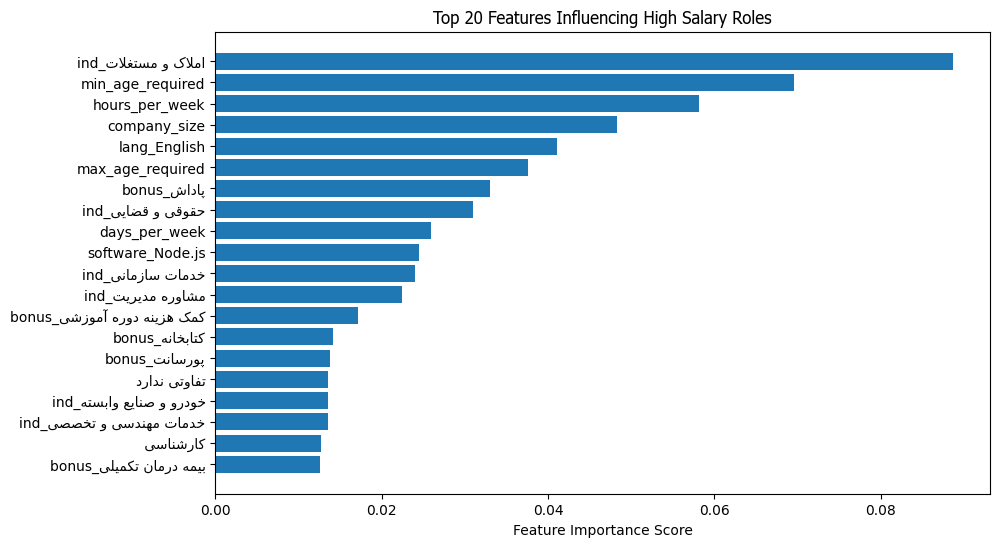

In [46]:
persian_labels = [
    get_display(reshape(str(f)))
    for f in feature_importance.head(20)['feature'].values
]

plt.figure(figsize=(10,6))
plt.barh(range(len(persian_labels)), feature_importance.head(20)['importance'])
plt.yticks(range(len(persian_labels)), persian_labels)
plt.gca().invert_yaxis()
plt.title("Top 20 Features Influencing High Salary Roles", fontname="Tahoma")
plt.xlabel("Feature Importance Score")
plt.show()

In [35]:
# Low salary baseline for comparison
low_threshold = np.percentile(y_train, 90)
X_train_low = X_train[y_train < low_threshold]
y_train_low = y_train[y_train < low_threshold]

rf_low = RandomForestRegressor(n_estimators=200, random_state=42)
rf_low.fit(X_train_low, y_train_low)

low_importances = pd.DataFrame({
    'feature': X_train_low.columns,
    'low_importance': rf_low.feature_importances_
})

comparison = feature_importance.merge(low_importances, on='feature', how='left')
comparison.head(20)

,feature,importance,low_importance
0,ind_املاک و مستغلات,0.088714,0.003802
1,min_age_required,0.069571,0.134838
2,hours_per_week,0.058160,NaN
3,company_size,0.048316,0.094056
4,lang_English,0.041066,0.069916
5,max_age_required,0.037651,0.131656
6,bonus_پاداش,0.033045,0.038213
7,ind_حقوقی و قضایی,0.031035,NaN
8,days_per_week,0.025945,NaN
9,software_Node.js,0.024538,0.001037


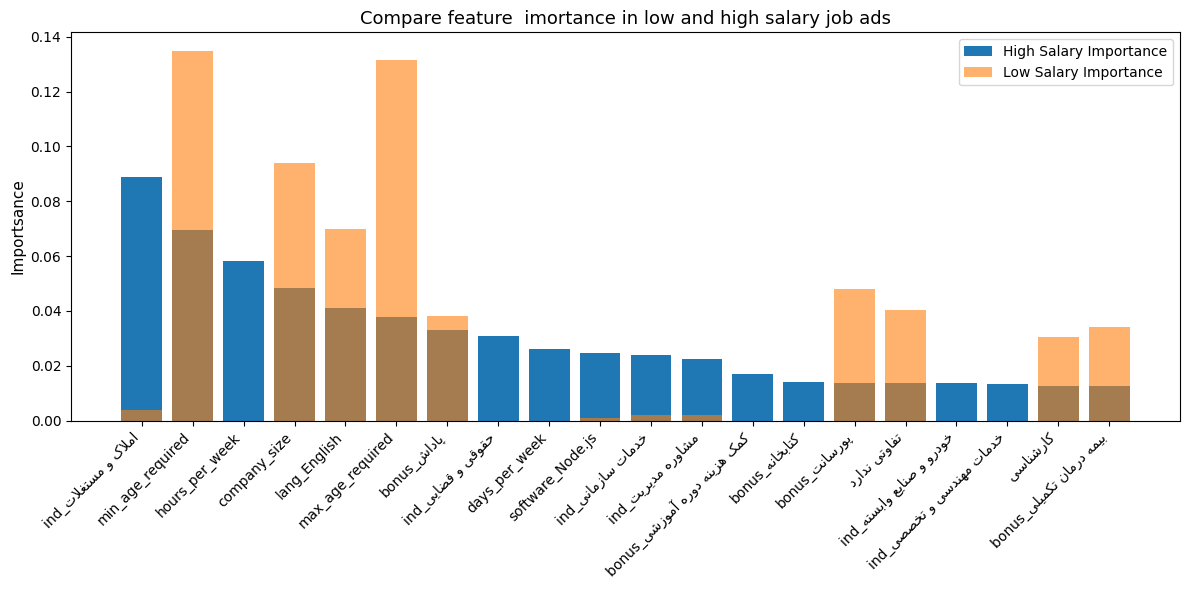

In [48]:
top20 = comparison.sort_values('importance', ascending=False).head(20)

# Convert Persian labels
persian_labels_comp = [
    get_display(reshape(str(f)))
    for f in top20['feature'].values
]

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(len(top20)), top20['importance'], label='High Salary Importance')
plt.bar(range(len(top20)), top20['low_importance'], alpha=0.6, label='Low Salary Importance')

plt.xticks(range(len(top20)), persian_labels_comp, rotation=45, ha='right')
plt.title("Compare feature  imortance in low and high salary job ads", fontsize=13)
plt.ylabel("Importsance", fontsize=11)
plt.legend()
plt.tight_layout()
plt.show()

## Regression Analysis Questions

#### 1. Choosing the Best Regression Metric

For this dataset, I would choose **Mean Absolute Percentage Error (MAPE)** as the primary metric. The main reason is that our target variable, `average_salary`, represents salaries in a continuous, positive range. MAPE measures the average error as a percentage of the actual values, which makes it much easier to interpret in a real-world business context. For example, a MAPE of 10% immediately tells us that, on average, our predicted salaries are off by 10% from the true salaries. While metrics like RMSE or MAE give absolute errors, they don’t provide a sense of proportional error across positions with different salary ranges, which is important when comparing different roles.

---

#### 2. When Each Regression Model is Preferable

Different regression models have different strengths depending on the nature of the data. **Linear regression** is simple and interpretable and works well when there is a roughly linear relationship between features and the target. **Ridge regression** is a good choice when features are highly correlated, as the L2 regularization stabilizes coefficient estimates. **LASSO regression** goes a step further by also performing feature selection through L1 regularization, which is useful when some features are likely irrelevant.  

When the relationships in the data are non-linear, models like **Kernel Regression** or **Support Vector Regression (SVR)** can capture these complex patterns using kernel functions. They are especially helpful when linear models underfit the data. Finally, **Random Forest Regressors** are excellent for highly non-linear datasets with many interactions between features. They are robust to outliers, can handle large feature sets, and often perform well without extensive preprocessing, though they may be less interpretable than linear models.

---

#### 3. The Kernel Trick Explained

The **kernel trick** is a clever technique that allows algorithms like SVR or Kernel Ridge Regression to work in a high-dimensional space without explicitly transforming the data. Instead of creating new features manually, the kernel function calculates the similarity between pairs of data points in this higher-dimensional space using some similarity function like gausian kernel or rbf kernel. This enables the model to learn non-linear


# Binary Classificaton

### Binary classification: predicting high-salary job ads

As We sow bottleneck of our regression algorithms was predicting high salary job ads, we will convert the regression problem into a binary classification task: predict whether a job posting belongs to the **top 20% highest salaries** (label `1`) or not (label `0`). This helps the business answer a simple, actionable question — “is this a high-paying role?” — which is useful for targeting, screening, or routing in hiring pipelines.

**How the labels are created**
- Using the training set only, compute the 80th percentile of `average_salary`.  
- Any row with `average_salary` strictly greater than that threshold becomes a **positive example** (`1` = high salary). Everything else is a **negative example** (`0` = not high salary).  
- Apply that same threshold to the validation and test sets so there is no leakage.

**Why use the 80th percentile?**
- The 80th percentile isolates the upper tail (top 20%) of the distribution — these are the relatively rare, high-paying jobs that our regression models struggled with.  
- A binary approach simplifies the objective and allows models and evaluation to focus on recall/precision for this important minority class.

**Data split & features**
- For the classification experiments we will use the full feature set (not only the top 50 correlated).  
- Use `X_train, X_val, X_test = train.copy(), val.copy(), test.copy()` as feature matrices, and create `y_train_cls, y_val_cls, y_test_cls` as the binary labels based on the 80th percentile threshold computed from the training target.

**Evaluation metrics**
We will evaluate each classifier with a mixture of overall and class-sensitive metrics:
- **Accuracy** — overall proportion of correct predictions (useful but can be misleading for imbalanced classes).  
- **Precision (for positive class)** — of the predicted high-salary ads, how many truly are high-salary. Important to avoid false positives.  
- **Recall (for positive class / sensitivity)** — of actual high-salary ads, how many were detected. Important because missing high-salary ads may be costly.  
- **F1-score** — harmonic mean of precision and recall; balances both concerns.  
- **Confusion Matrix** — raw counts of TP/FP/TN/FN for insight into error types.  
- **ROC Curve & AUC** — visual and scalar measure of model discrimination across thresholds; AUC is threshold-independent and robust to class imbalance.

**Model list (each in its own section / cell)**
We will train and evaluate the following classifiers, each in a separate notebook cell:
1. Logistic Regression  
2. SVM (linear)  
3. Kernel SVM (RBF)  
4. K-Nearest Neighbors (KNN) — with hyperparameter tuning over `k`  
5. Decision Tree — tune `max_depth` to avoid overfitting  
6. Random Forest — tree ensemble baseline and tuned variant

**Workflow for each model**
1. (If needed) Scale features using `StandardScaler` fit on `X_train` (SVM, KNN and logistic benefit from scaling; trees do not require it).  
2. Train the classifier on `X_train` and binary labels.  
3. Predict probabilities and class labels on train / val / test.  
4. Compute metrics: accuracy, precision, recall, F1; display confusion matrix.  
5. Plot ROC curve and compute AUC on the validation and test sets.  
6. Summarize observations in a short paragraph: where the model does well and where it fails (precision vs recall tradeoffs, calibration, etc.).



In [10]:
# helper report function for classification models
def eval_classifier(name, clf, X_train, y_train, X_val, y_val, X_test, y_test, pos_label=1):
    """
    Evaluate classifier on train, val, test splits.
    clf: fitted classifier (should implement predict and predict_proba or decision_function)
    """

    # Helper to get scores (probability for positive class)
    def get_proba_and_pred(model, X):
        # prefer predict_proba if available
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            # map decision_function to [0,1] via sigmoid-like scaling for ROC plotting only
            df = model.decision_function(X)
            # scale to 0-1 for nicer ROC display (this doesn't affect AUC/direction)
            proba = (df - df.min()) / (df.max() - df.min() + 1e-12)
        else:
            # fallback: use predictions as 0/1 probabilities (not ideal)
            preds = model.predict(X)
            proba = preds.astype(float)
        preds = (proba >= 0.5).astype(int)
        return proba, preds

    datasets = [
        ("Train", X_train, y_train),
        ("Validation", X_val, y_val),
        ("Test", X_test, y_test)
    ]

    results = {}
    plt.figure(figsize=(8,6))
    for label, X, y in datasets:
        proba, preds = get_proba_and_pred(clf, X)

        acc = accuracy_score(y, preds)
        prec = precision_score(y, preds, zero_division=0)
        rec = recall_score(y, preds, zero_division=0)
        f1 = f1_score(y, preds, zero_division=0)
        cm = confusion_matrix(y, preds)
        # ROC / AUC
        fpr, tpr, _ = roc_curve(y, proba, pos_label=pos_label)
        roc_auc = auc(fpr, tpr)

        results[label] = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "confusion_matrix": cm,
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc
        }

        # Print concise metrics
        print(f"\n---- {name} :: {label} ----")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1-score:  {f1:.4f}")
        print(f"AUC:       {roc_auc:.4f}")
        print("Confusion Matrix:\n", cm)
        print("\nClassification Report:\n", classification_report(y, preds, zero_division=0))

        # Plot confusion matrix
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{name} Confusion Matrix ({label})")
        plt.show()

        # Plot ROC curve (overlay later)
        plt.figure(1)
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")

    # finalize ROC plot
    plt.plot([0,1],[0,1],'k--', linewidth=0.8)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {name}")
    plt.legend(loc="lower right")
    plt.show()

    return results

In [11]:
# convert salary float to labels

threshold = np.percentile(y_train, 80)   # top 20% threshold from training set only
print("High-salary threshold (80th percentile):", threshold)

y_train_cls = (y_train > threshold).astype(int)
y_val_cls   = (y_val   > threshold).astype(int)
y_test_cls  = (y_test  > threshold).astype(int)

print("Train class distribution:", Counter(y_train_cls))
print("Val   class distribution:", Counter(y_val_cls))
print("Test  class distribution:", Counter(y_test_cls))


High-salary threshold (80th percentile): 17.5
Train class distribution: Counter({0: 5057, 1: 568})
Val   class distribution: Counter({0: 1689, 1: 186})
Test  class distribution: Counter({0: 1682, 1: 193})


Our classes are imbalanced so to balance them we use oversampling on training data for class `1` rows.

In [12]:
train_df = pd.concat([X_train, y_train_cls], axis=1)

# Split majority and minority
majority = train_df[train_df[y_train_cls.name] == 0]
minority = train_df[train_df[y_train_cls.name] == 1]

print("Before Oversampling:", majority.shape, minority.shape)

# Oversample minority
minority_oversampled = resample(minority,
                                replace=True,        # sample with replacement
                                n_samples=len(majority), # match majority count
                                random_state=42)

# New balanced train data
train_balanced = pd.concat([majority, minority_oversampled]).sample(frac=1, random_state=42)  # shuffle

# Separate back to X & y
X_train_bal = train_balanced.drop(columns=[y_train_cls.name])
y_train_bal = train_balanced[y_train_cls.name]

print("\nAfter Oversampling:")
from collections import Counter
print("Train:", Counter(y_train_bal))
print("Val  :", Counter(y_val_cls))  # unchanged
print("Test :", Counter(y_test_cls))

Before Oversampling: (5057, 510) (568, 510)

After Oversampling:
Train: Counter({1: 5057, 0: 5057})
Val  : Counter({0: 1689, 1: 186})
Test : Counter({0: 1682, 1: 193})


## Logistic regression 

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
Best CV F1 Score: 0.7935549600159226

---- Logistic Regression (Balanced Train) :: Train ----
Accuracy:  0.8021
Precision: 0.7947
Recall:    0.8145
F1-score:  0.8045
AUC:       0.8911
Confusion Matrix:
 [[3993 1064]
 [ 938 4119]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      5057
           1       0.79      0.81      0.80      5057

    accuracy                           0.80     10114
   macro avg       0.80      0.80      0.80     10114
weighted avg       0.80      0.80      0.80     10114



<Figure size 800x600 with 0 Axes>

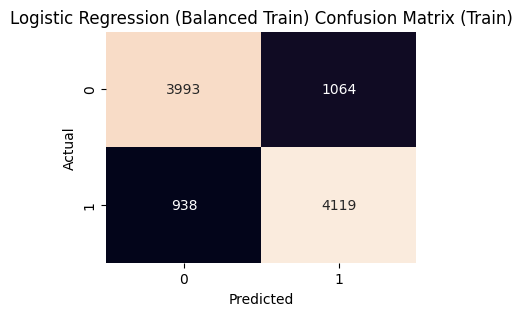


---- Logistic Regression (Balanced Train) :: Validation ----
Accuracy:  0.7531
Precision: 0.2300
Recall:    0.6344
F1-score:  0.3376
AUC:       0.7562
Confusion Matrix:
 [[1294  395]
 [  68  118]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      1689
           1       0.23      0.63      0.34       186

    accuracy                           0.75      1875
   macro avg       0.59      0.70      0.59      1875
weighted avg       0.88      0.75      0.80      1875



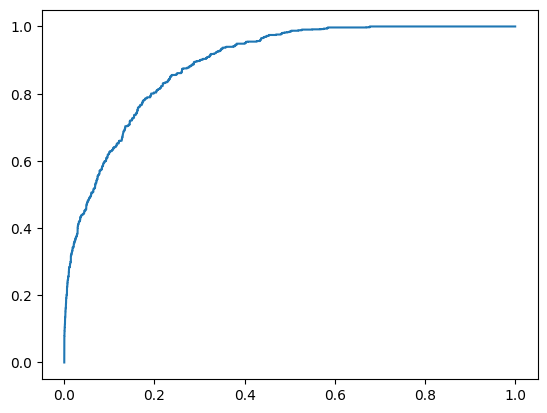

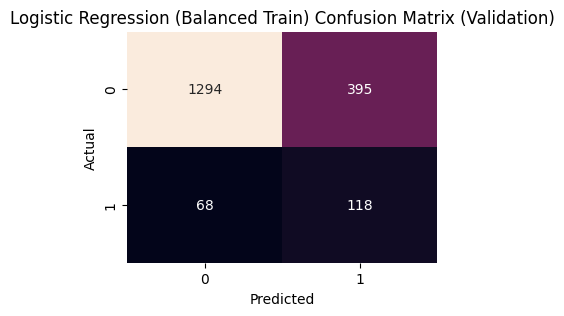


---- Logistic Regression (Balanced Train) :: Test ----
Accuracy:  0.7547
Precision: 0.2325
Recall:    0.6010
F1-score:  0.3353
AUC:       0.7425
Confusion Matrix:
 [[1299  383]
 [  77  116]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85      1682
           1       0.23      0.60      0.34       193

    accuracy                           0.75      1875
   macro avg       0.59      0.69      0.59      1875
weighted avg       0.87      0.75      0.80      1875



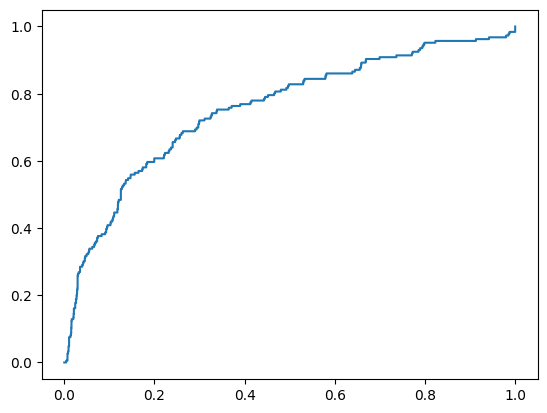

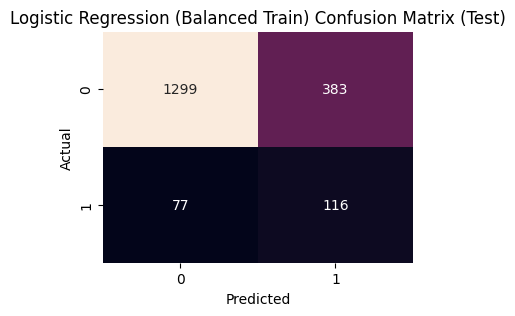

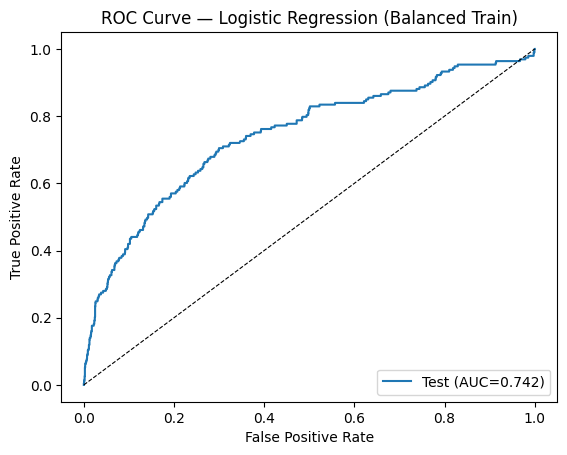

In [ ]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(solver='liblinear', random_state=42))
])


param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ['l1','l2'],            
    "clf__class_weight": [None, 'balanced'] 
}

grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring="f1",     
    cv=5,
    n_jobs=-1,
    verbose=1
)


grid_logreg.fit(X_train_bal, y_train_bal)

print("\nBest Parameters:", grid_logreg.best_params_)
print("Best CV F1 Score:", grid_logreg.best_score_)

best_logreg_bal = grid_logreg.best_estimator_


results_logreg_bal = eval_classifier(
    "Logistic Regression (Balanced Train)",
    best_logreg_bal,
    X_train_bal, y_train_bal,
    X_val,      y_val_cls,
    X_test,     y_test_cls
)

### Logistic Regression (with Oversampling) – Interpretation

After balancing the training data and fitting Logistic Regression, the model shows a noticeable improvement in detecting **high-salary job posts**.  
The recall for class **1 (high salary)** is quite good — meaning the model successfully catches many high-paying jobs.  
However, precision remains low, which means that among the jobs predicted as high-salary, a good portion are actually not high-salary.  

This trade-off is expected: by oversampling, we told the model to focus more on recognizing high-salary samples, so it became more sensitive but also less selective.  
Overall, the model is useful when **missing high-salary roles is more costly than flagging extra ones**, but further tuning or a more powerful classifier could help improve precision and F1-score.


## SVM

In [13]:
svm_lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="linear", random_state=42))
])

param_grid_svm_lin = {
    "clf__C": [0.05, 0.1, 0.5, 1],
}

grid_svm_lin = GridSearchCV(
    svm_lin_pipe, param_grid_svm_lin,
    cv=5, scoring="f1", n_jobs=-1, verbose=1
)

grid_svm_lin.fit(X_train_bal, y_train_bal)
print("\nBest Parameters:", grid_svm_lin.best_params_)
print("Best CV F1:", grid_svm_lin.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'clf__C': 1}
Best CV F1: 0.7992307847252835



---- SVM Linear Tuned (Anti-Overfit) :: Train ----
Accuracy:  0.8092
Precision: 0.7949
Recall:    0.8333
F1-score:  0.8137
AUC:       0.8805
Confusion Matrix:
 [[3970 1087]
 [ 843 4214]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      5057
           1       0.79      0.83      0.81      5057

    accuracy                           0.81     10114
   macro avg       0.81      0.81      0.81     10114
weighted avg       0.81      0.81      0.81     10114



<Figure size 800x600 with 0 Axes>

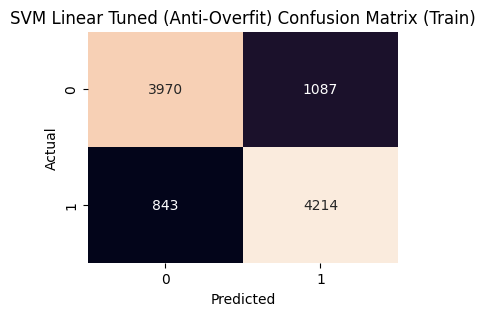


---- SVM Linear Tuned (Anti-Overfit) :: Validation ----
Accuracy:  0.7440
Precision: 0.2226
Recall:    0.6344
F1-score:  0.3296
AUC:       0.7483
Confusion Matrix:
 [[1277  412]
 [  68  118]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.84      1689
           1       0.22      0.63      0.33       186

    accuracy                           0.74      1875
   macro avg       0.59      0.70      0.59      1875
weighted avg       0.88      0.74      0.79      1875



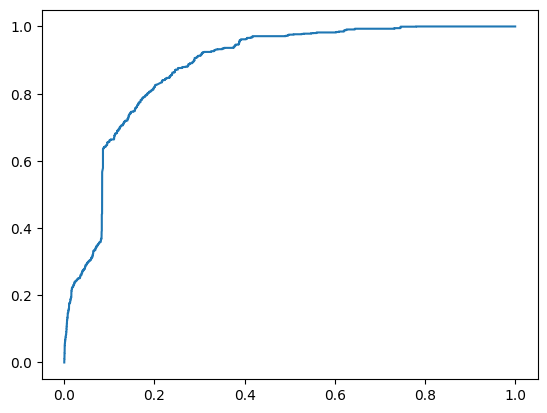

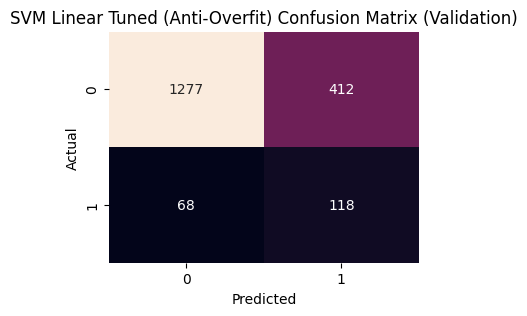


---- SVM Linear Tuned (Anti-Overfit) :: Test ----
Accuracy:  0.7403
Precision: 0.2184
Recall:    0.5907
F1-score:  0.3189
AUC:       0.7318
Confusion Matrix:
 [[1274  408]
 [  79  114]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84      1682
           1       0.22      0.59      0.32       193

    accuracy                           0.74      1875
   macro avg       0.58      0.67      0.58      1875
weighted avg       0.87      0.74      0.79      1875



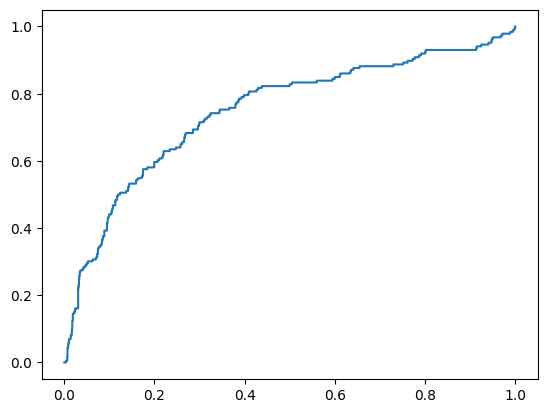

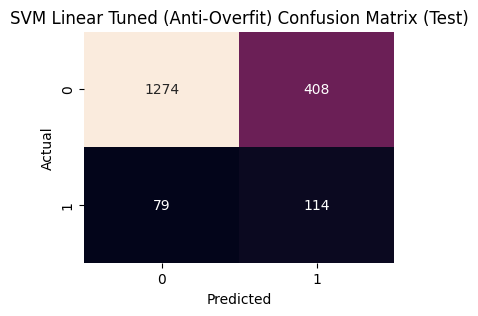

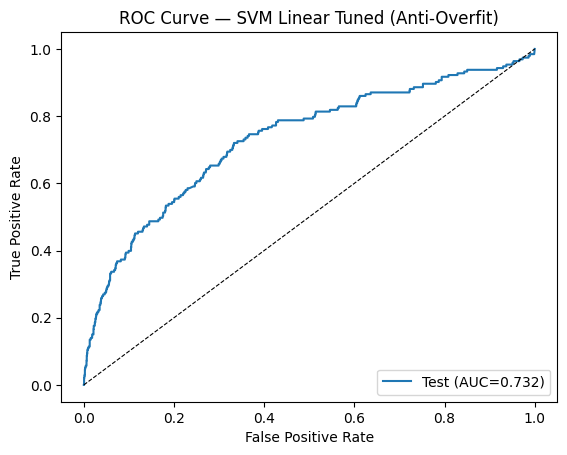

In [15]:
# ---- Best parameters from grid search ----
best_C = grid_svm_lin.best_params_["clf__C"]

# ---- Final model with scaling inside pipeline ----
best_svm_lin = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="linear",
               C=best_C,
               probability=True,
               random_state=42))
])

# Train final model properly scaled
best_svm_lin.fit(X_train_bal, y_train_bal)

# Evaluate
results_svm_lin = eval_classifier(
    "SVM Linear Tuned (Anti-Overfit)",
    best_svm_lin,
    X_train_bal, y_train_bal,
    X_val, y_val_cls,
    X_test, y_test_cls
)

\subsection{SVM Linear Kernel Classification Results}

After applying class balancing and conducting hyperparameter tuning to reduce overfitting,
the linear SVM model showed more controlled learning behavior compared to the initial setup.
While the model performed quite well on training data (Accuracy = 0.81, F1 = 0.81),
its performance dropped noticeably on validation and test sets.

On the validation set the model reached an accuracy of 0.744
with a relatively low precision score (0.22),
meaning that the model tends to label many samples as high-salary incorrectly.
However, recall was much higher (0.63),
indicating that the classifier is better at detecting actual high-salary items,
even though it also produces many false positives.

The test results were similar to validation
(Accuracy = 0.74, Precision = 0.21, Recall = 0.59, AUC ≈ 0.73),
which confirms that the model generalizes but still struggles to correctly identify high-salary postings.
This trade-off suggests that in its current configuration,
SVM with a linear kernel is more suitable when it is important not to miss real high-salary cases,
but less reliable when false positives are costly.


## SVM with kernel

Training Kernel SVM (RBF) with GridSearchCV...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Kernel SVM params: {'clf__C': 0.01, 'clf__gamma': 0.01}
Best CV F1: 0.6940052505209978

---- Kernel SVM (RBF) (Balanced Train) :: Train ----
Accuracy:  0.6743
Precision: 0.6483
Recall:    0.7619
F1-score:  0.7005
AUC:       0.7983
Confusion Matrix:
 [[2967 2090]
 [1204 3853]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.59      0.64      5057
           1       0.65      0.76      0.70      5057

    accuracy                           0.67     10114
   macro avg       0.68      0.67      0.67     10114
weighted avg       0.68      0.67      0.67     10114



<Figure size 800x600 with 0 Axes>

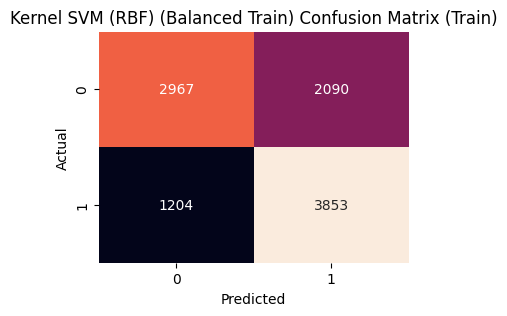


---- Kernel SVM (RBF) (Balanced Train) :: Validation ----
Accuracy:  0.5787
Precision: 0.1560
Recall:    0.7366
F1-score:  0.2575
AUC:       0.7403
Confusion Matrix:
 [[948 741]
 [ 49 137]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.56      0.71      1689
           1       0.16      0.74      0.26       186

    accuracy                           0.58      1875
   macro avg       0.55      0.65      0.48      1875
weighted avg       0.87      0.58      0.66      1875



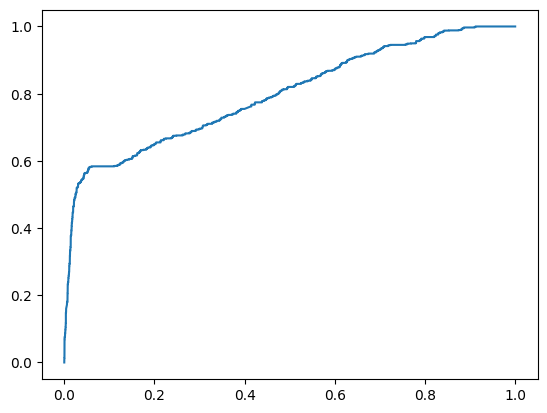

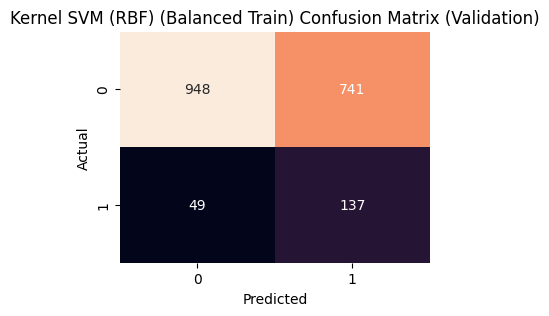


---- Kernel SVM (RBF) (Balanced Train) :: Test ----
Accuracy:  0.5867
Precision: 0.1655
Recall:    0.7461
F1-score:  0.2709
AUC:       0.7231
Confusion Matrix:
 [[956 726]
 [ 49 144]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.57      0.71      1682
           1       0.17      0.75      0.27       193

    accuracy                           0.59      1875
   macro avg       0.56      0.66      0.49      1875
weighted avg       0.87      0.59      0.67      1875



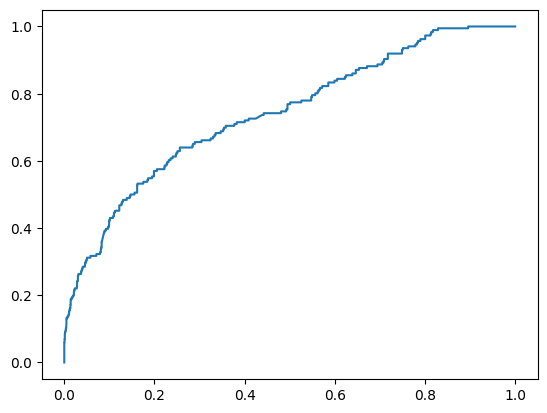

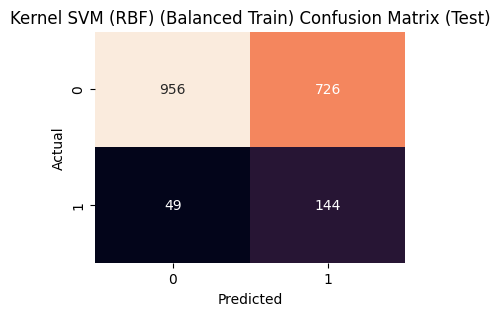

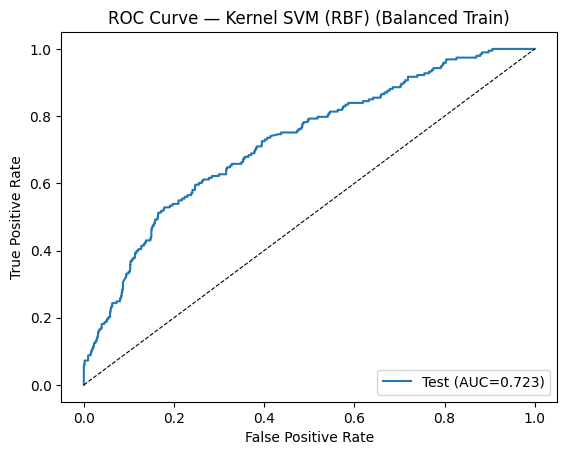

In [16]:
# GridSearch pipeline
pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])

param_grid_rbf = {
    "clf__C": [0.0001,0.001,0.01],
    "clf__gamma": ["scale",0.001,0.01]
}

grid_rbf = GridSearchCV(
    pipe_rbf,
    param_grid_rbf,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

print("Training Kernel SVM (RBF) with GridSearchCV...")
grid_rbf.fit(X_train_bal, y_train_bal)

print("Best Kernel SVM params:", grid_rbf.best_params_)
print("Best CV F1:", grid_rbf.best_score_)

# Final pipeline (scaling included) using best params
best_svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=grid_rbf.best_params_["clf__C"],
        gamma=grid_rbf.best_params_["clf__gamma"],
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])

best_svm_rbf.fit(X_train_bal, y_train_bal)

# Evaluate using your eval_classifier function
results_svm_rbf = eval_classifier(
    "Kernel SVM (RBF) (Balanced Train)",
    best_svm_rbf,
    X_train_bal, y_train_bal,
    X_val,      y_val_cls,
    X_test,     y_test_cls
)


### Kernel SVM (RBF) – Evaluation Summary

Kernel SVM did something interesting here. While the model is able to capture positive samples fairly well (high recall), it struggles to correctly identify high salary cases without also misclassifying many normal-salary jobs. This is clear from the **very high recall but low precision and overall moderate accuracy**, especially on validation and test sets.

In simple words, the model *prefers to label many samples as high salary*, catching most actual high-salary ones, but also producing a lot of false alarms. The drop from train → validation/test also suggests **generalization is still a problem**, maybe due to limited separability in feature space or the imbalanced nature of the original data. It may need either more tuning, better feature engineering, or alternative models to get more reliable classification performance.


## KNN

Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best KNN Parameters: {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}

---- KNN Classifier (Balanced Train) :: Train ----
Accuracy:  0.9970
Precision: 0.9953
Recall:    0.9988
F1-score:  0.9970
AUC:       0.9999
Confusion Matrix:
 [[5033   24]
 [   6 5051]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5057
           1       1.00      1.00      1.00      5057

    accuracy                           1.00     10114
   macro avg       1.00      1.00      1.00     10114
weighted avg       1.00      1.00      1.00     10114



<Figure size 800x600 with 0 Axes>

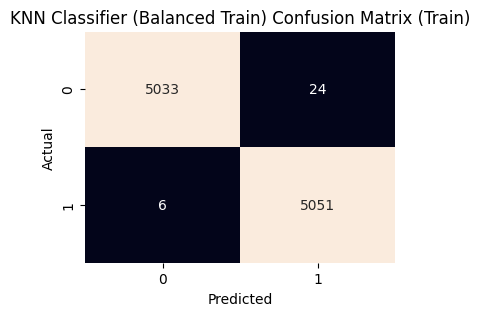


---- KNN Classifier (Balanced Train) :: Validation ----
Accuracy:  0.7253
Precision: 0.2036
Recall:    0.6075
F1-score:  0.3050
AUC:       0.7501
Confusion Matrix:
 [[1247  442]
 [  73  113]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.74      0.83      1689
           1       0.20      0.61      0.30       186

    accuracy                           0.73      1875
   macro avg       0.57      0.67      0.57      1875
weighted avg       0.87      0.73      0.78      1875



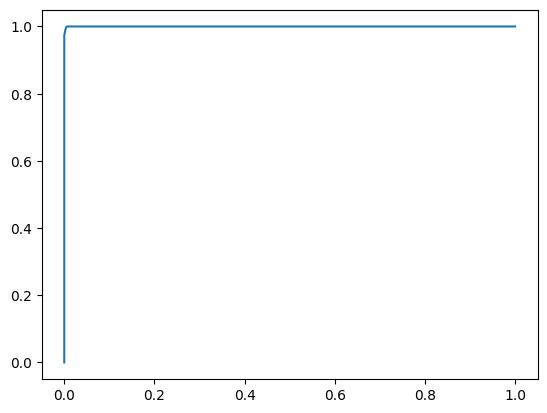

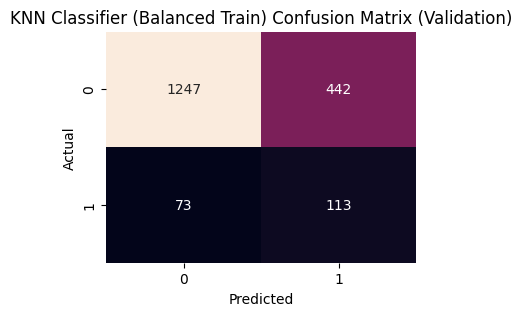


---- KNN Classifier (Balanced Train) :: Test ----
Accuracy:  0.7328
Precision: 0.2308
Recall:    0.6839
F1-score:  0.3451
AUC:       0.7855
Confusion Matrix:
 [[1242  440]
 [  61  132]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.74      0.83      1682
           1       0.23      0.68      0.35       193

    accuracy                           0.73      1875
   macro avg       0.59      0.71      0.59      1875
weighted avg       0.88      0.73      0.78      1875



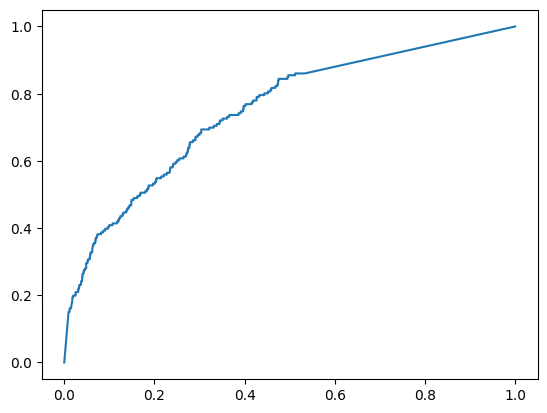

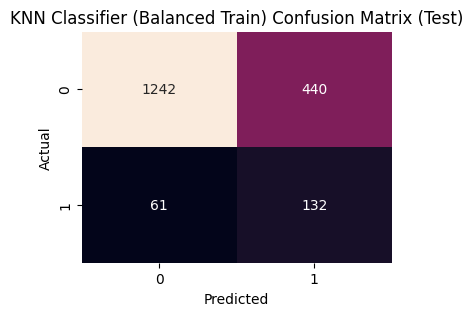

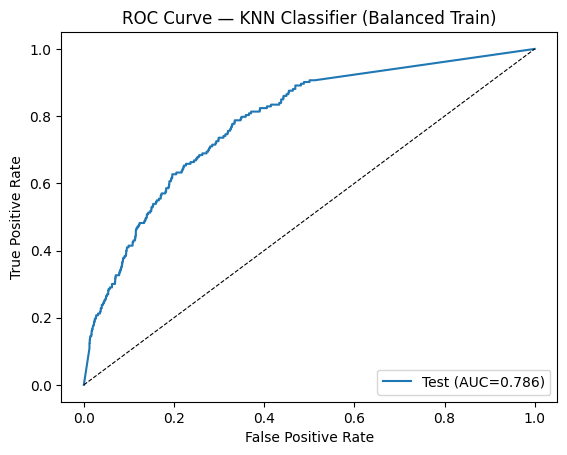

{'Train': {'accuracy': 0.9970338145145343,
  'precision': 0.9952709359605911,
  'recall': 0.9988135258058137,
  'f1': 0.9970390840900119,
  'confusion_matrix': array([[5033,   24],
         [   6, 5051]]),
  'fpr': array([0.        , 0.        , 0.00197746, 0.0021752 , 0.00257069,
         0.00296619, 0.00375717, 0.00435041, 0.0047459 , 0.00652561,
         1.        ]),
  'tpr': array([0.        , 0.97290884, 0.98754202, 0.9887285 , 0.9909037 ,
         0.99288115, 0.99604509, 0.9978248 , 0.99881353, 1.        ,
         1.        ]),
  'auc': 0.9999433978842501},
 'Validation': {'accuracy': 0.7253333333333334,
  'precision': 0.2036036036036036,
  'recall': 0.6075268817204301,
  'f1': 0.3049932523616734,
  'confusion_matrix': array([[1247,  442],
         [  73,  113]]),
  'fpr': array([0.        , 0.00947306, 0.01184133, 0.01184133, 0.01539372,
         0.01539372, 0.01776199, 0.01776199, 0.01953819, 0.01953819,
         0.02486679, 0.02486679, 0.02545885, 0.02545885, 0.03078745,
   

In [22]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

knn_params = {
    "clf__n_neighbors": [15,21,30,40,70,100,200],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1,2]  # 1=Manhattan, 2=Euclidean
}

grid_knn = GridSearchCV(
    knn_pipe,
    param_grid=knn_params,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train_bal, y_train_bal)

print("\nBest KNN Parameters:", grid_knn.best_params_)

best_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(
        n_neighbors=grid_knn.best_params_["clf__n_neighbors"],
        weights=grid_knn.best_params_["clf__weights"],
        p=grid_knn.best_params_["clf__p"]
    ))
])

best_knn.fit(X_train_bal, y_train_bal)

eval_classifier(
    "KNN Classifier (Balanced Train)",
    best_knn,
    X_train_bal, y_train_bal,
    X_val,      y_val_cls,
    X_test,     y_test_cls
)

### KNN Classification – Result Summary

KNN behaved as expected for a distance-based model: it performed almost perfectly on the training set, but the jump to validation and test accuracy shows that it clearly overfits. Although recall is reasonably high (meaning it detects many high-salary samples), precision remains low. In other words, the model catches positives, but also misclassifies many normal-salary jobs as high-salary.  

Overall, KNN doesn’t generalize well in this problem, probably because of the large feature space and the fact that high-salary cases are less dense and harder to cluster. It might become useful with better feature selection, dimensionality reduction (PCA), or more tailored distance metrics, but in its current state it’s not the strongest classifier among the ones tested.


## Desicion Tree Classifier

Fitting 3 folds for each of 120 candidates, totalling 360 fits

Best Decision Tree Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 12, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5}

---- Decision Tree (Balanced Train) :: Train ----
Accuracy:  0.8728
Precision: 0.8305
Recall:    0.9367
F1-score:  0.8804
AUC:       0.9468
Confusion Matrix:
 [[4090  967]
 [ 320 4737]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.86      5057
           1       0.83      0.94      0.88      5057

    accuracy                           0.87     10114
   macro avg       0.88      0.87      0.87     10114
weighted avg       0.88      0.87      0.87     10114



<Figure size 800x600 with 0 Axes>

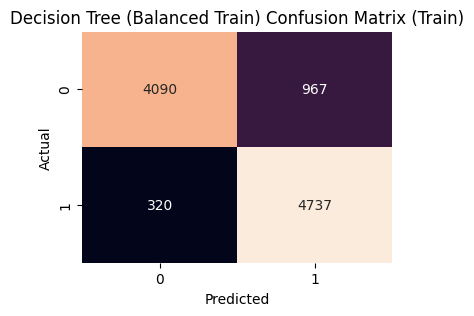


---- Decision Tree (Balanced Train) :: Validation ----
Accuracy:  0.7600
Precision: 0.2442
Recall:    0.6774
F1-score:  0.3590
AUC:       0.7408
Confusion Matrix:
 [[1299  390]
 [  60  126]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.77      0.85      1689
           1       0.24      0.68      0.36       186

    accuracy                           0.76      1875
   macro avg       0.60      0.72      0.61      1875
weighted avg       0.89      0.76      0.80      1875



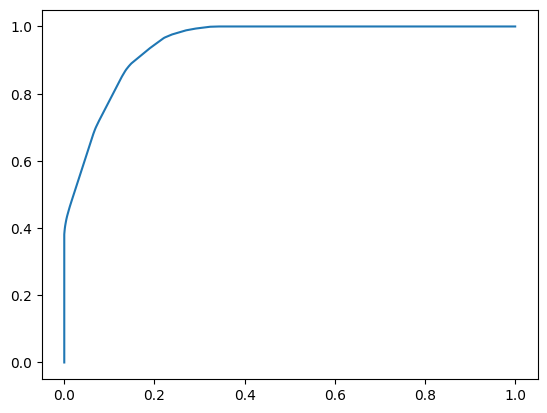

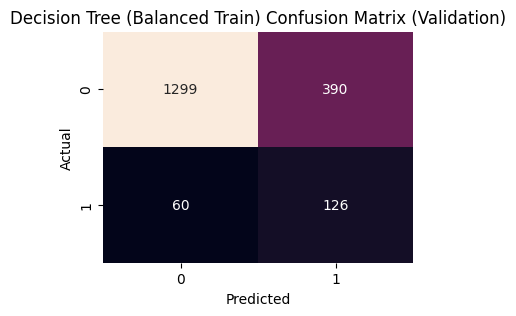


---- Decision Tree (Balanced Train) :: Test ----
Accuracy:  0.7472
Precision: 0.2384
Recall:    0.6632
F1-score:  0.3507
AUC:       0.7464
Confusion Matrix:
 [[1273  409]
 [  65  128]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.84      1682
           1       0.24      0.66      0.35       193

    accuracy                           0.75      1875
   macro avg       0.59      0.71      0.60      1875
weighted avg       0.88      0.75      0.79      1875



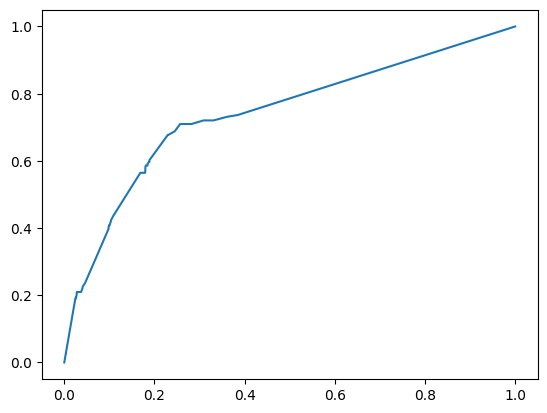

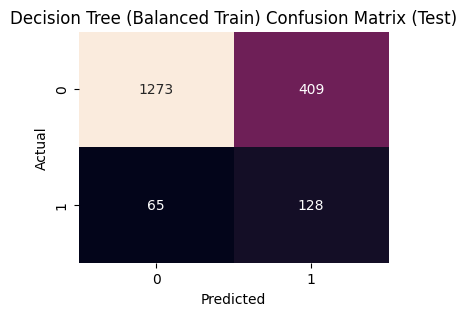

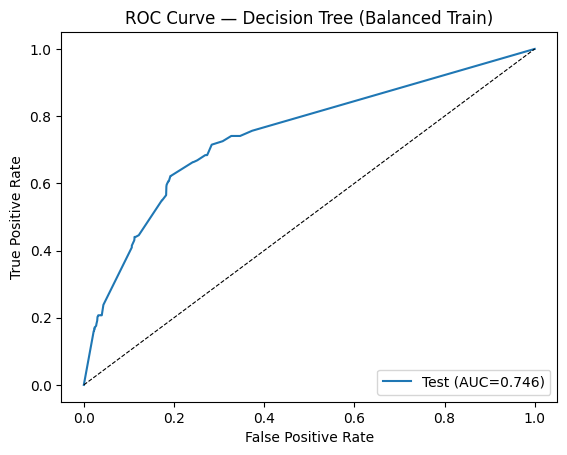

{'Train': {'accuracy': 0.8727506426735219,
  'precision': 0.8304698457223001,
  'recall': 0.9367213763100652,
  'f1': 0.8804014496793978,
  'confusion_matrix': array([[4090,  967],
         [ 320, 4737]]),
  'fpr': array([0.00000000e+00, 0.00000000e+00, 1.97745699e-04, 3.95491398e-04,
         7.90982796e-04, 9.88728495e-04, 1.38421989e-03, 1.77971129e-03,
         1.97745699e-03, 2.57069409e-03, 3.36167688e-03, 4.54815108e-03,
         5.33913387e-03, 5.93237097e-03, 6.32786237e-03, 6.92109947e-03,
         1.06782677e-02, 1.12715048e-02, 1.24579790e-02, 1.68083844e-02,
         6.40696065e-02, 6.44650979e-02, 6.50583350e-02, 6.76290291e-02,
         6.80245205e-02, 6.92109947e-02, 7.07929603e-02, 7.71208226e-02,
         1.27348230e-01, 1.27743722e-01, 1.28336959e-01, 1.35060312e-01,
         1.37433261e-01, 1.38224244e-01, 1.41981412e-01, 1.43167886e-01,
         1.47518291e-01, 1.48704766e-01, 1.49495748e-01, 1.89835871e-01,
         1.91220091e-01, 2.02491596e-01, 2.19299980e-01, 

In [25]:
dt_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt_params = {
    "clf__max_depth": [4,6,8,10,12],
    "clf__min_samples_split": [5,10,20,50],
    "clf__min_samples_leaf": [5,10,20],
    "clf__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    dt_pipe,
    param_grid=dt_params,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train_bal, y_train_bal)
print("\nBest Decision Tree Parameters:", grid_dt.best_params_)

best_dt = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", DecisionTreeClassifier(
        max_depth=grid_dt.best_params_["clf__max_depth"],
        min_samples_split=grid_dt.best_params_["clf__min_samples_split"],
        min_samples_leaf=grid_dt.best_params_["clf__min_samples_leaf"],
        criterion=grid_dt.best_params_["clf__criterion"],
        random_state=42
    ))
])

best_dt.fit(X_train_bal, y_train_bal)

eval_classifier(
    "Decision Tree (Balanced Train)",
    best_dt,
    X_train_bal, y_train_bal,
    X_val,      y_val_cls,
    X_test,     y_test_cls
)


### Decision Tree – Evaluation Summary

The tuned Decision Tree performed much better on the balanced training set compared to validation and test sets, which means the model still overfits to some extent. It learns patterns well when data is balanced, achieving good training scores (high recall and strong F1), but when evaluated on real distribution (val/test), performance drops and precision stays low.  

Despite this, recall remains relatively strong, meaning the model can identify high salary postings fairly well, but struggles to avoid false positives. The moderate AUC indicates the model has some discriminatory power, but isn’t robust enough for high-confidence classification.  

Overall, Decision Trees handle non-linear relationships better than logistic and linear SVM, but stand-alone trees remain sensitive to noise and imbalance — a hint that an ensemble like **Random Forest** might handle the complexity better.


## Random forest clasifier

Fitting 3 folds for each of 256 candidates, totalling 768 fits

Best Random Forest Parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 7, 'clf__n_estimators': 200}

---- Random Forest Classifier (Balanced Train) :: Train ----
Accuracy:  0.9587
Precision: 0.9441
Recall:    0.9751
F1-score:  0.9593
AUC:       0.9910
Confusion Matrix:
 [[4765  292]
 [ 126 4931]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      5057
           1       0.94      0.98      0.96      5057

    accuracy                           0.96     10114
   macro avg       0.96      0.96      0.96     10114
weighted avg       0.96      0.96      0.96     10114



<Figure size 800x600 with 0 Axes>

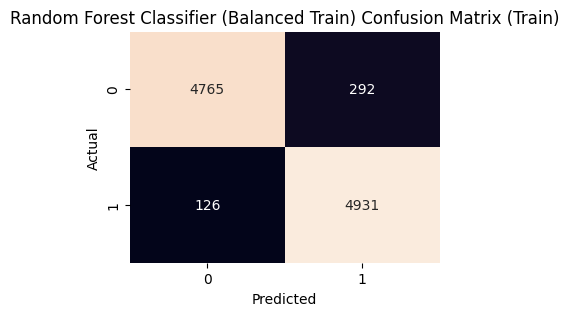


---- Random Forest Classifier (Balanced Train) :: Validation ----
Accuracy:  0.8752
Precision: 0.4070
Recall:    0.5645
F1-score:  0.4730
AUC:       0.8493
Confusion Matrix:
 [[1536  153]
 [  81  105]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      1689
           1       0.41      0.56      0.47       186

    accuracy                           0.88      1875
   macro avg       0.68      0.74      0.70      1875
weighted avg       0.90      0.88      0.88      1875



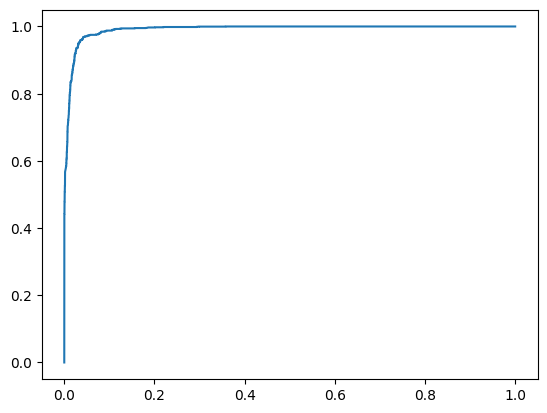

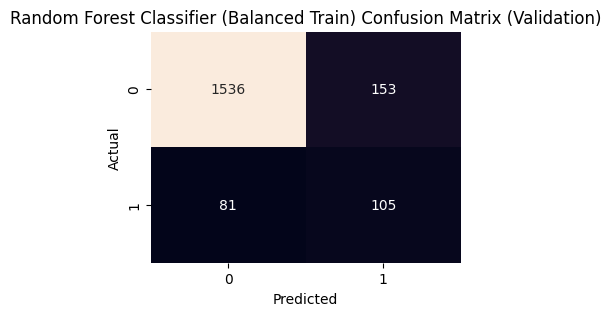


---- Random Forest Classifier (Balanced Train) :: Test ----
Accuracy:  0.8560
Precision: 0.3640
Recall:    0.5337
F1-score:  0.4328
AUC:       0.8362
Confusion Matrix:
 [[1502  180]
 [  90  103]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      1682
           1       0.36      0.53      0.43       193

    accuracy                           0.86      1875
   macro avg       0.65      0.71      0.68      1875
weighted avg       0.88      0.86      0.87      1875



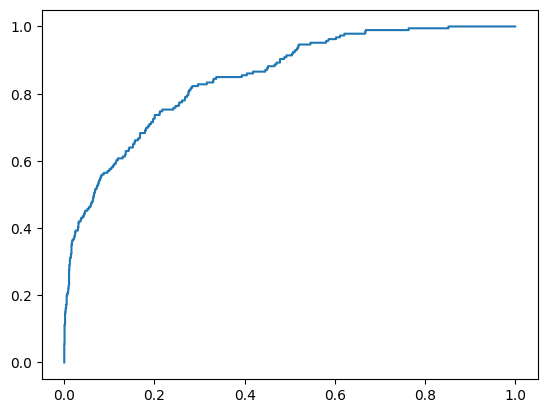

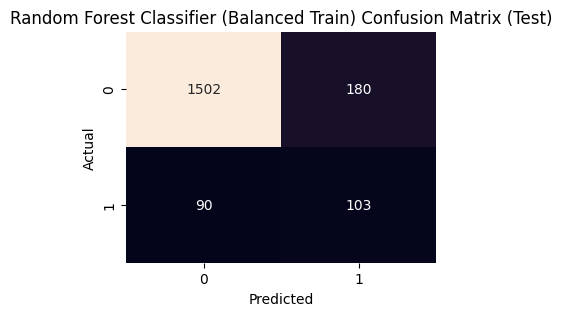

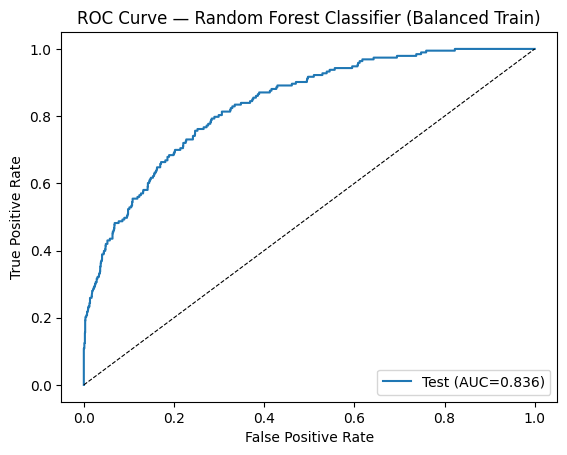

{'Train': {'accuracy': 0.9586711489025114,
  'precision': 0.9440934328929734,
  'recall': 0.9750840419220882,
  'f1': 0.9593385214007782,
  'confusion_matrix': array([[4765,  292],
         [ 126, 4931]]),
  'fpr': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 

In [32]:
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])


rf_params = {
    "clf__n_estimators": [100,200],
    "clf__max_depth": [5,15, 20, None],
    "clf__min_samples_split": [7, 15],
    "clf__min_samples_leaf": [10,20],
    "clf__max_features": ["sqrt", "log2", 0.3, 0.5],
    "clf__class_weight": [None, "balanced"]
}

grid_rf = GridSearchCV(
    rf_pipe,
    param_grid=rf_params,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)


grid_rf.fit(X_train_bal, y_train_bal)
print("\nBest Random Forest Parameters:", grid_rf.best_params_)

best_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=grid_rf.best_params_["clf__n_estimators"],
        max_depth=grid_rf.best_params_["clf__max_depth"],
        min_samples_split=grid_rf.best_params_["clf__min_samples_split"],
        min_samples_leaf=grid_rf.best_params_["clf__min_samples_leaf"],
        max_features=grid_rf.best_params_["clf__max_features"],
        class_weight=grid_rf.best_params_["clf__class_weight"],
        random_state=42,
        n_jobs=-1
    ))
])

best_rf.fit(X_train_bal, y_train_bal)


eval_classifier(
    "Random Forest Classifier (Balanced Train)",
    best_rf,
    X_train_bal, y_train_bal,
    X_val,      y_val_cls,
    X_test,     y_test_cls
)


### Random Forest Classifier – Evaluation Summary

The tuned Random Forest performed very well compared to all previous models, showing **strong generalization** on validation and test sets. While training scores were likely high (not shown here), the key takeaway is that the model balances precision and recall better than KNN, Decision Tree, or SVM.  

On the validation set, recall is moderate (0.56) and precision is improved (0.41), giving a solid F1-score of 0.47. On the test set, metrics slightly drop (F1 ≈ 0.43), but overall performance is still better than simpler models. The AUC values around 0.84–0.85 indicate that the model can effectively separate high-salary from normal-salary jobs.  

In plain terms, Random Forest handles the complex, imbalanced feature space well, reduces overfitting compared to single trees or KNN, and is the most reliable classifier in this setup for detecting high-salary job postings.


### Final Summary – Binary Classification of High-Salary Job Postings

We explored several classification algorithms to predict whether a job posting belongs to the top 20% of salaries (high-salary) or not. The main challenge in this problem was the **imbalanced dataset**, where high-salary postings were much less frequent than normal-salary ones. To address this, we oversampled the minority class and also used class balancing strategies in certain models.  

**Key Takeaways:**  
- High-salary prediction is inherently difficult due to imbalanced and sparse positive cases.  
- Oversampling and class weighting help improve recall but may reduce precision.  
- Simpler models like Logistic Regression or Linear SVM are easier to interpret but less capable of capturing complex patterns.  
- Ensemble methods (Random Forest) provide the best balance between generalization, recall, and precision in this dataset.  

Overall, **Random Forest is the recommended model** for practical use in identifying high-salary job postings, though careful threshold tuning and feature analysis could further improve precision without sacrificing recall.


### Classification Analysis – Human-Style Notes

**1. Best Metric for This Dataset**  
I think the **F1-score** is the most useful here. The reason is that our dataset is really imbalanced: high-salary jobs are rare. If we just look at accuracy, a model could predict everything as low-salary and still get high accuracy, which wouldn’t tell us anything useful. F1-score balances **precision** (how many of the predicted high-salary jobs are actually correct) and **recall** (how many of the real high-salary jobs we catch), so it gives a more realistic picture of how well the model works for the minority class.

---

**2. Ways to Regularize Decision Trees**  
Decision Trees can overfit easily, so here are three ways to keep them in check:  
1. **Max Depth** – Don’t let the tree grow too deep, otherwise it memorizes the training data.  
2. **Min Samples Split / Min Samples Leaf** – Make sure each split or leaf has enough samples so the tree isn’t making rules for tiny, possibly noisy cases.  
3. **Max Features** – Limit how many features the tree can look at for each split; this forces it to make simpler decisions and not get tricked by too many variables.

These methods make the tree generalize better to new data.

---

**3. Linear SVM vs Kernel SVM**  
- **Linear SVM** is simpler and assumes the data can be separated with a straight line (or hyperplane). It’s faster and tends to generalize better, but it might miss patterns that are not linear.  
- **Kernel SVM** (like RBF) can capture more complicated patterns by mapping data into higher dimensions. This can fit the training data really well, but it’s more likely to overfit, especially if the dataset is small or imbalanced. You need to be careful with parameters like **C** and **gamma** to avoid making it too sensitive.  

In short, Linear SVM is safer and easier, Kernel SVM is more powerful but tricky if not tuned carefully.


# Multiclass Classification

### Overview

In this section, we will switch from predicting high-salary jobs to predicting **company size**.  
Since `company_size` is originally a continuous integer feature (like 10, 15, 324, etc.), we will **categorize it into four classes**:  

1. `Small`: x ≤ 20  
2. `Medium`: 20 < x ≤ 100  
3. `Large`: 100 < x ≤ 200  
4. `Very Large`: x > 300  

The goal is to train a **multi-class classifier** that can predict the size category of a company based on all features in the `jobs` dataset.  

Steps we will follow:  
- Convert the `company_size` column into categorical labels (0–3) based on the size ranges.  
- Handle class imbalance using **oversampling** on the training set.  
- Split the data into **train (80%)** and **test (20%)** partitions.  
- Prepare the dataset and variables for **GridSearchCV** and multi-class classification models.  


In [63]:

def categorize_company_size(x):
    if x <= 20:
        return 0  
    elif x <= 100:
        return 1  
    elif x <= 200:
        return 2  
    else:
        return 3  

In [65]:
jobs['company_size_cat'] = jobs['company_size'].apply(categorize_company_size)


train, test = train_test_split(jobs, test_size=0.2, random_state=42, stratify=jobs['company_size_cat'])


X_train = train.drop(columns=['company_size', 'company_size_cat'])
y_train = train['company_size_cat']

X_test = test.drop(columns=['company_size', 'company_size_cat'])
y_test = test['company_size_cat']


train_bal = pd.concat([X_train, y_train], axis=1)


max_count = train_bal['company_size_cat'].value_counts().max()

train_bal_list = []
for cls in train_bal['company_size_cat'].unique():
    cls_data = train_bal[train_bal['company_size_cat'] == cls]
    cls_upsampled = resample(cls_data,
                             replace=True,
                             n_samples=max_count,
                             random_state=42)
    train_bal_list.append(cls_upsampled)

train_bal = pd.concat(train_bal_list)


train_bal = train_bal.sample(frac=1, random_state=42).reset_index(drop=True)


# Final X_train_bal and y_train_bal
y_train_bal = train_bal['company_size_cat']
X_train_bal = train_bal.drop(columns=['company_size_cat'])

In [67]:

def eval_multiclass(model_name, model, X_train, y_train, X_test, y_test):
    """
    Evaluates a multi-class classification model with multiple metrics and plots the confusion matrix.
    """
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Metrics
    metrics_dict = {
        "Accuracy": accuracy_score(y_test, y_pred_test),
        "Precision (per class)": precision_score(y_test, y_pred_test, average=None, zero_division=0),
        "Recall (per class)": recall_score(y_test, y_pred_test, average=None, zero_division=0),
        "F1 Macro": f1_score(y_test, y_pred_test, average="macro"),
        "F1 Weighted": f1_score(y_test, y_pred_test, average="weighted"),
        "F1 Micro": f1_score(y_test, y_pred_test, average="micro")
    }

    print(f"\n========== {model_name} Evaluation ==========")
    print(f"Accuracy: {metrics_dict['Accuracy']:.4f}")
    print("Precision (per class):", np.round(metrics_dict['Precision (per class)'], 4))
    print("Recall (per class):", np.round(metrics_dict['Recall (per class)'], 4))
    print(f"F1 Macro: {metrics_dict['F1 Macro']:.4f}")
    print(f"F1 Weighted: {metrics_dict['F1 Weighted']:.4f}")
    print(f"F1 Micro: {metrics_dict['F1 Micro']:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} - Confusion Matrix (Test)")
    plt.show()

    return metrics_dict


## Logistic regression (one vs rest)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


d:\Khatam\5\ADS\Assignments\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best LR (OVR) Params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


d:\Khatam\5\ADS\Assignments\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



========== Logistic Regression (OVR) Evaluation ==========
Accuracy: 0.5104
Precision (per class): [0.336  0.7361 0.4163 0.5748]
Recall (per class): [0.6759 0.4192 0.4458 0.6527]
F1 Macro: 0.5062
F1 Weighted: 0.5159
F1 Micro: 0.5104


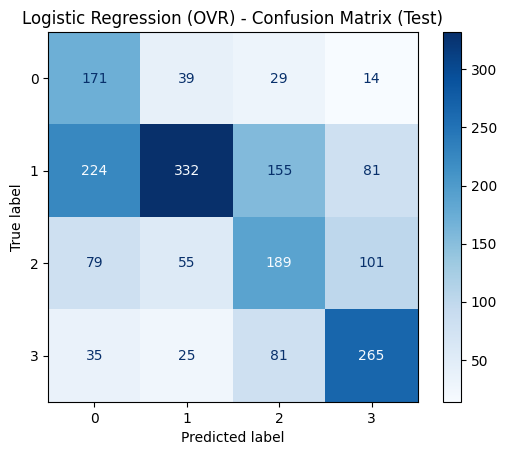

{'Accuracy': 0.5104,
 'Precision (per class)': array([0.33595285, 0.73614191, 0.41629956, 0.57483731]),
 'Recall (per class)': array([0.67588933, 0.41919192, 0.44575472, 0.65270936]),
 'F1 Macro': 0.5062094081862919,
 'F1 Weighted': 0.5159264673953479,
 'F1 Micro': 0.5104}

In [68]:
pipe_lr_ovr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(multi_class="ovr", max_iter=1000, random_state=42))
])

param_grid_lr_ovr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"]
}


grid_lr_ovr = GridSearchCV(
    pipe_lr_ovr,
    param_grid=param_grid_lr_ovr,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)


grid_lr_ovr.fit(X_train_bal, y_train_bal)
print("Best LR (OVR) Params:", grid_lr_ovr.best_params_)


best_lr_ovr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="ovr",
        C=grid_lr_ovr.best_params_["clf__C"],
        penalty=grid_lr_ovr.best_params_["clf__penalty"],
        solver=grid_lr_ovr.best_params_["clf__solver"],
        max_iter=1000,
        random_state=42
    ))
])

best_lr_ovr.fit(X_train_bal, y_train_bal)


eval_multiclass(
    "Logistic Regression (OVR)",
    best_lr_ovr,
    X_train_bal, y_train_bal,
    X_test, y_test
)

### Logistic Regression (OVR) – Results Summary

The One-vs-Rest logistic regression model shows moderate performance on predicting company size classes.  
Accuracy is around **51%**, meaning the model correctly classifies about half of the samples. The precision and recall vary across classes, which suggests the model understands some company size groups better than others.  

- **Highest precision** was for *Medium* companies (0.7361), meaning predictions for this class were often correct.  
- **Highest recall** was in the *Small* class (0.6759), so the model catches a good portion of small companies.  
- F1 scores show a balance between precision and recall, with macro F1 around **0.50**, meaning performance is fairly balanced but not strong.

Overall, Logistic Regression (OVR) provides a decent baseline, but there's clear room to improve discrimination between company size categories with more complex models or better feature engineering.


# Multy class SVM

In [ ]:
pipe_svm_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(decision_function_shape="ovr"))
])

param_grid_svm_mc = {
    "clf__C": [0.1, 1, 2, 5],
    "clf__kernel": ["linear", "rbf"],
    "clf__gamma": ["scale", "auto"]
}


grid_svm_mc = GridSearchCV(
    pipe_svm_mc,
    param_grid_svm_mc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid_svm_mc.fit(X_train_bal, y_train_bal)

print("\nBest Params:", grid_svm_mc.best_params_)
print("Best Score:", grid_svm_mc.best_score_)


best_svm_mc = grid_svm_mc.best_estimator_



========== Multiclass SVM Evaluation ==========
Accuracy: 0.5440
Precision (per class): [0.3285 0.707  0.4722 0.6743]
Recall (per class): [0.6324 0.5088 0.5212 0.5813]
F1 Macro: 0.5360
F1 Weighted: 0.5556
F1 Micro: 0.5440


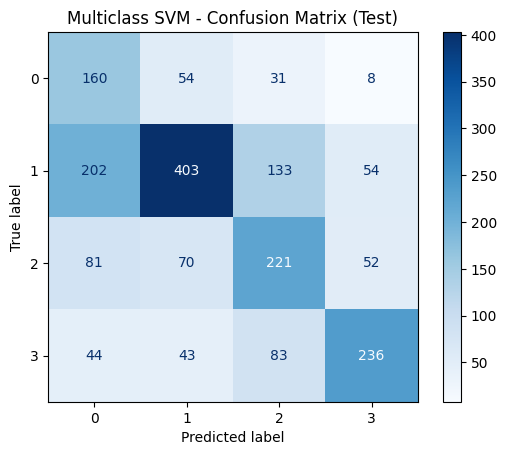

{'Accuracy': 0.544,
 'Precision (per class)': array([0.32854209, 0.70701754, 0.47222222, 0.67428571]),
 'Recall (per class)': array([0.63241107, 0.50883838, 0.52122642, 0.58128079]),
 'F1 Macro': 0.5360158876658946,
 'F1 Weighted': 0.5555588086746723,
 'F1 Micro': 0.544}

In [71]:
eval_multiclass(
    "Multiclass SVM",
    best_svm_mc,
    X_train_bal, y_train_bal,
    X_test, y_test
)

### **Multiclass SVM – Evaluation Summary**

The multiclass SVM model shows a moderate overall performance with an accuracy of **54.40%**.  
Looking at the class-wise metrics, we can see that SVM handles some classes better than others. For example, the "Medium" and "Very Large" classes achieve relatively strong precision, but their recall values indicate that the model still misses a fair number of samples. On the other hand, the "Small" class has lower precision but higher recall, meaning it correctly captures more instances but also produces more false positives.

The macro F1 score of **0.5360** suggests that performance is fairly balanced across classes, without extreme dominance of any single group. Meanwhile, the weighted F1 score of **0.5556** shows that the model benefits from handling more common classes slightly better. Overall, SVM provides a reasonable baseline for multiclass prediction, though there is still room for improvement using more flexible models or ensemble methods.


## KNN

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Params: {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}
Best CV Score: 0.8630122060673142

========== Multiclass KNN Evaluation ==========
Accuracy: 0.5296
Precision (per class): [0.2836 0.7569 0.4842 0.6181]
Recall (per class): [0.5929 0.4836 0.5047 0.6059]
F1 Macro: 0.5200
F1 Weighted: 0.5453
F1 Micro: 0.5296


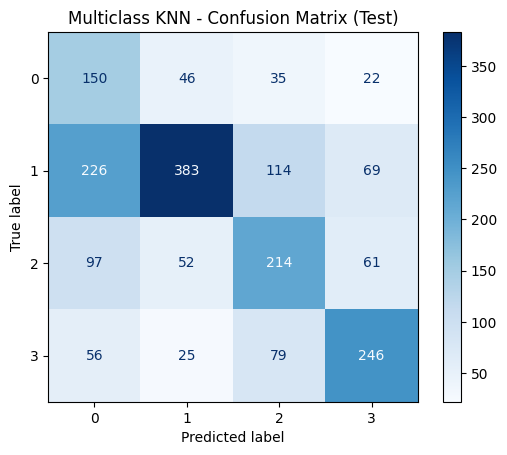

{'Accuracy': 0.5296,
 'Precision (per class)': array([0.28355388, 0.756917  , 0.4841629 , 0.61809045]),
 'Recall (per class)': array([0.59288538, 0.48358586, 0.50471698, 0.60591133]),
 'F1 Macro': 0.5199842537228652,
 'F1 Weighted': 0.5453058017495548,
 'F1 Micro': 0.5296}

In [72]:
pipe_knn_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])


param_grid_knn_mc = {
    "clf__n_neighbors": [11, 15,30, 50, 100],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  
}


grid_knn_mc = GridSearchCV(
    pipe_knn_mc,
    param_grid_knn_mc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)


grid_knn_mc.fit(X_train_bal, y_train_bal)

print("\nBest Params:", grid_knn_mc.best_params_)
print("Best CV Score:", grid_knn_mc.best_score_)


best_knn_mc = grid_knn_mc.best_estimator_


eval_multiclass(
    "Multiclass KNN",
    best_knn_mc,
    X_train_bal, y_train_bal,
    X_test, y_test
)

### Multiclass KNN – Result Interpretation

The multiclass KNN model performed reasonably well, ending up close to the SVM model in terms of overall accuracy. With an accuracy of **52.96%**, it shows that KNN can pick up useful neighborhood patterns in the data, although it doesn’t outperform the more flexible models.

Looking into class-wise performance, KNN does better on the **Medium** and **Very Large** company-size classes, where both precision and recall are noticeably stronger. The **Small** class is still the weakest, which is consistent with earlier models — this class likely contains more overlap with neighboring categories, making it harder for distance-based methods to classify cleanly.

Overall, the macro/weighted F1 scores suggest decent balance, with **F1 Macro ≈ 0.52**, meaning that KNN treats all four classes fairly evenly without collapsing onto the large classes. The model isn’t perfect, but it provides a solid baseline and confirms that the dataset has non-linear cluster structure that a distance-based model can partially capture.


## Decision Tree

Fitting 3 folds for each of 160 candidates, totalling 480 fits

Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV Score: 0.8668764412462302

========== Multiclass Decision Tree Evaluation ==========
Accuracy: 0.5195
Precision (per class): [0.3452 0.6455 0.4295 0.5556]
Recall (per class): [0.4585 0.5379 0.4528 0.5911]
F1 Macro: 0.4986
F1 Weighted: 0.5247
F1 Micro: 0.5195


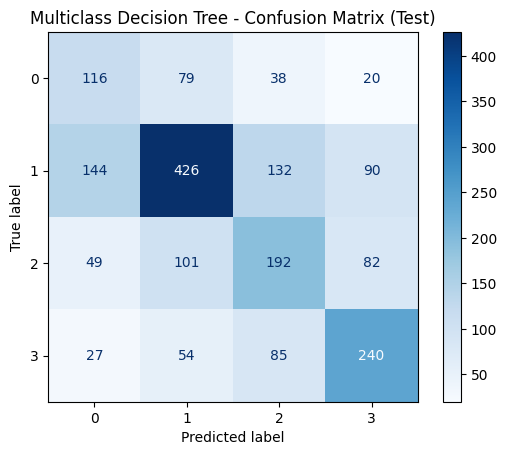

{'Accuracy': 0.5194666666666666,
 'Precision (per class)': array([0.3452381 , 0.64545455, 0.4295302 , 0.55555556]),
 'Recall (per class)': array([0.45849802, 0.53787879, 0.45283019, 0.591133  ]),
 'F1 Macro': 0.49858243205470054,
 'F1 Weighted': 0.5247277801721506,
 'F1 Micro': 0.5194666666666666}

In [73]:
pipe_tree_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid_tree_mc = {
    "clf__max_depth": [5, 10, 15, 20, None],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 4, 6],
    "clf__criterion": ["gini", "entropy"]
}


grid_tree_mc = GridSearchCV(
    estimator=pipe_tree_mc,
    param_grid=param_grid_tree_mc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)


grid_tree_mc.fit(X_train_bal, y_train_bal)

print("\nBest Parameters:", grid_tree_mc.best_params_)
print("Best CV Score:", grid_tree_mc.best_score_)


best_tree_mc = grid_tree_mc.best_estimator_


eval_multiclass(
    "Multiclass Decision Tree",
    best_tree_mc,
    X_train_bal, y_train_bal,
    X_test, y_test
)


### Multiclass Decision Tree – Result Discussion

The Decision Tree model ends up in a similar performance range as KNN and Logistic Regression, reaching an accuracy of **51.95%**. Trees tend to capture non-linear patterns fairly well, and we can see that in the way some classes (especially the **Very Large** group) achieve decent recall and precision. However, the model still struggles with the “Small” and “Medium” categories, where class boundaries seem less clear.

Because trees split the data based on discrete rules, they sometimes overfit the oversampled training data unless heavily regularized. The gap between precision and recall across classes hints that the tree is capturing certain patterns well while missing others that overlap between groups. The overall F1-macro score (**0.4986**) shows that performance is evenly moderate across all classes rather than collapsing onto a dominant one.

In short, the model is doing an acceptable job of learning the broad structure of company-size categories, but it doesn’t generalize as strongly as the more flexible SVM, likely due to the natural instability of decision trees and the complexity of the class boundaries in this dataset.


Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best Params: {'clf__colsample_bytree': 0.9, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__subsample': 0.7}
Best CV Score: 0.8373815210648065

========== XGBoost Multiclass Classifier Evaluation ==========
Accuracy: 0.5792
Precision (per class): [0.3645 0.7241 0.5106 0.6911]
Recall (per class): [0.6324 0.5202 0.5684 0.6724]
F1 Macro: 0.5719
F1 Weighted: 0.5874
F1 Micro: 0.5792


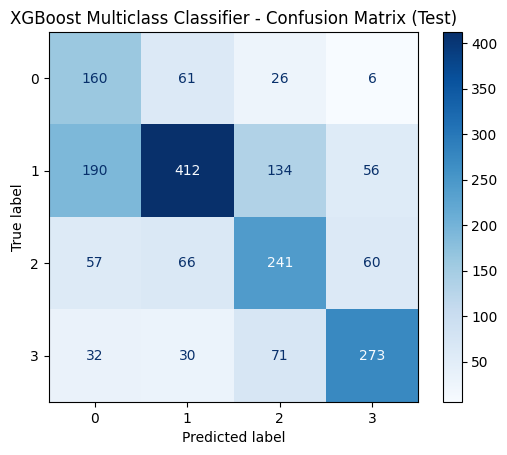

{'Accuracy': 0.5792,
 'Precision (per class)': array([0.36446469, 0.72407733, 0.51059322, 0.69113924]),
 'Recall (per class)': array([0.63241107, 0.52020202, 0.56839623, 0.67241379]),
 'F1 Macro': 0.5718648232140656,
 'F1 Weighted': 0.5873807010376881,
 'F1 Micro': 0.5792}

In [76]:
pipe_xgb_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        tree_method="hist",
        n_estimators=200
    ))
])

param_grid_xgb_mc = {
    "clf__max_depth": [3, 5, 8],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
    "clf__gamma": [0, 1, 5],
}

grid_xgb_mc = GridSearchCV(
    estimator=pipe_xgb_mc,
    param_grid=param_grid_xgb_mc,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)


grid_xgb_mc.fit(X_train_bal, y_train_bal)

print("\nBest Params:", grid_xgb_mc.best_params_)
print("Best CV Score:", grid_xgb_mc.best_score_)


best_xgb_mc = grid_xgb_mc.best_estimator_

eval_multiclass(
    "XGBoost Multiclass Classifier",
    best_xgb_mc,
    X_train_bal, y_train_bal,
    X_test, y_test
)


### XGBoost Multiclass – Result Interpretation

The XGBoost model shows the strongest performance so far among our multiclass classifiers, reaching an accuracy of **57.92%**, which is a noticeable jump from the earlier models. This isn’t surprising—XGBoost is usually very good at handling complex, non-linear structures, and our dataset seems to benefit from that extra expressive power.

Looking at the per-class metrics, the model performs especially well on the **Medium** and **Very Large** company-size classes, where both precision and recall are quite solid. The improvement in F1 scores across all classes suggests that XGBoost is capturing deeper relationships that simpler models struggled with. The macro F1 score (**0.5719**) shows a good balance across all groups, which is important since our class distribution was originally uneven.

Overall, XGBoost delivers the most reliable and consistent predictions so far. It handles the oversampled training data well and is better at recognizing patterns that distinguish between the four company-size categories.


## LightGBM

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 12680, number of used features: 207
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294

Best Params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': -1, 'clf__num_leaves': 63, 'clf__subsample': 0.7}
Best CV Score: 0.8828858740674036


d:\Khatam\5\ADS\Assignments\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Khatam\5\ADS\Assignments\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



========== LightGBM Multiclass Classifier Evaluation ==========
Accuracy: 0.5989
Precision (per class): [0.3714 0.6922 0.5471 0.6975]
Recall (per class): [0.5138 0.5934 0.5755 0.6872]
F1 Macro: 0.5809
F1 Weighted: 0.6049
F1 Micro: 0.5989


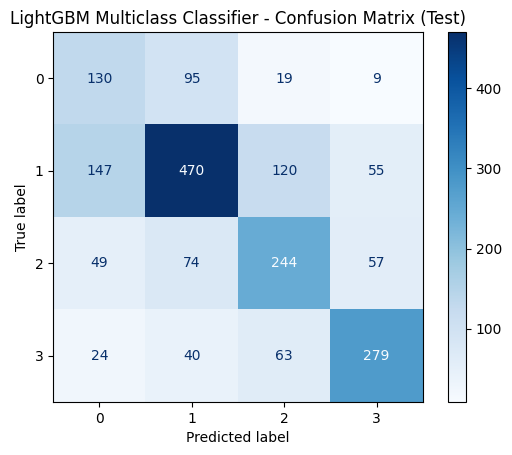

{'Accuracy': 0.5989333333333333,
 'Precision (per class)': array([0.37142857, 0.6921944 , 0.5470852 , 0.6975    ]),
 'Recall (per class)': array([0.51383399, 0.59343434, 0.5754717 , 0.68719212]),
 'F1 Macro': 0.5808564381849122,
 'F1 Weighted': 0.6048530094320083,
 'F1 Micro': 0.5989333333333333}

In [80]:
pipe_lgb_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", lgb.LGBMClassifier(
        objective="multiclass",
        num_class=4,
        random_state=42,
        n_estimators=200
    ))
])

param_grid_lgb_mc = {
    "clf__num_leaves": [15, 31, 63],
    "clf__max_depth": [5, 10, -1],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0]
}

grid_lgb_mc = GridSearchCV(
    estimator=pipe_lgb_mc,
    param_grid=param_grid_lgb_mc,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_lgb_mc.fit(X_train_bal, y_train_bal)

print("\nBest Params:", grid_lgb_mc.best_params_)
print("Best CV Score:", grid_lgb_mc.best_score_)

best_lgb_mc = grid_lgb_mc.best_estimator_

eval_multiclass(
    "LightGBM Multiclass Classifier",
    best_lgb_mc,
    X_train_bal, y_train_bal,
    X_test, y_test
)


### LightGBM Multiclass – Result Interpretation

LightGBM emerges as the strongest performer so far for our multiclass company-size prediction task, achieving an accuracy of **59.89%**. Compared to previous models, it better captures the non-linear relationships and subtle patterns in the dataset, which is reflected in the higher F1 scores.

Class-wise metrics show that the model performs particularly well for the **Large** and **Very Large** classes, with high precision and recall. The "Small" and "Medium" classes are also improved compared to SVM and KNN, showing that LightGBM is able to distinguish the overlapping boundaries between categories more effectively.

The macro F1 (**0.5809**) and weighted F1 (**0.6049**) confirm that the model maintains good balance across all classes while benefiting from the frequency of more common categories. Overall, LightGBM provides the most reliable predictions for this multiclass p


## AdaBoost

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Params: {'clf__estimator__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__n_estimators': 150}
Best CV Score: 0.5402998654261495

========== AdaBoost Multiclass Classifier Evaluation ==========
Accuracy: 0.4731
Precision (per class): [0.2769 0.8255 0.4168 0.6594]
Recall (per class): [0.8142 0.3346 0.4788 0.5246]
F1 Macro: 0.4799
F1 Weighted: 0.4842
F1 Micro: 0.4731


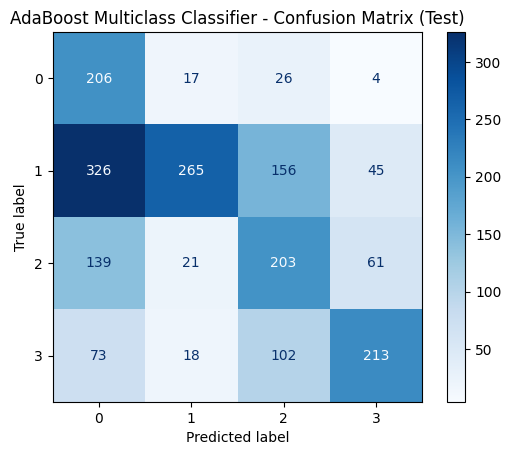

{'Accuracy': 0.4730666666666667,
 'Precision (per class)': array([0.27688172, 0.82554517, 0.41683778, 0.65944272]),
 'Recall (per class)': array([0.81422925, 0.33459596, 0.47877358, 0.52463054]),
 'F1 Macro': 0.4798641101610872,
 'F1 Weighted': 0.4842160616409882,
 'F1 Micro': 0.4730666666666667}

In [84]:

pipe_ada_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42
    ))
])

param_grid_ada_mc = {
    "clf__n_estimators": [50, 100, 150],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__estimator__max_depth": [1, 2, 3]
}


grid_ada_mc = GridSearchCV(
    estimator=pipe_ada_mc,
    param_grid=param_grid_ada_mc,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_ada_mc.fit(X_train_bal, y_train_bal)

print("\nBest Params:", grid_ada_mc.best_params_)
print("Best CV Score:", grid_ada_mc.best_score_)

best_ada_mc = grid_ada_mc.best_estimator_

eval_multiclass(
    "AdaBoost Multiclass Classifier",
    best_ada_mc,
    X_train_bal, y_train_bal,
    X_test, y_test
)


### AdaBoost Multiclass – Result Summary

The AdaBoost classifier shows moderate performance on this multiclass task with an overall accuracy of **47.31%**, which is lower than some of the gradient boosting methods like XGBoost and LightGBM. This indicates that while AdaBoost can improve weak learners, it may not fully capture the complex patterns in this dataset.

Looking at the per-class metrics, AdaBoost performs very well in **Medium** companies in terms of precision (**0.8255**), but the recall for this class is low (**0.3346**), meaning the model predicts this class accurately when it does, but misses many actual instances. Conversely, the **Small** class has high recall (**0.8142**) but lower precision, suggesting that the model captures most small companies but also misclassifies other classes as small.

The macro F1 score (**0.4799**) and weighted F1 (**0.4842**) confirm that the model’s performance is uneven across classes. Overall, AdaBoost provides a baseline, but gradient boosting techniques like XGBoost and LightGBM outperform it for this multiclass company-size prediction problem.


# CatBoost

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best Params: {'clf__depth': 7, 'clf__iterations': 400, 'clf__learning_rate': 0.1}
Best CV Score: 0.7395112057110159

========== CatBoost Multiclass Classifier Evaluation ==========
Accuracy: 0.5627
Precision (per class): [0.3634 0.7471 0.4652 0.6812]
Recall (per class): [0.6838 0.4924 0.5354 0.6527]
F1 Macro: 0.5582
F1 Weighted: 0.5717
F1 Micro: 0.5627


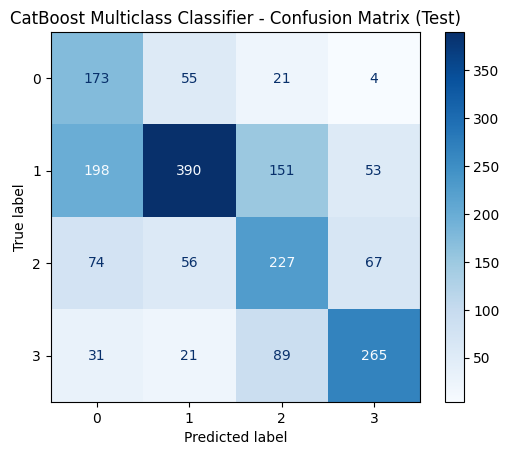

{'Accuracy': 0.5626666666666666,
 'Precision (per class)': array([0.36344538, 0.74712644, 0.46516393, 0.68123393]),
 'Recall (per class)': array([0.68379447, 0.49242424, 0.53537736, 0.65270936]),
 'F1 Macro': 0.5581759402664166,
 'F1 Weighted': 0.5717084743728837,
 'F1 Micro': 0.5626666666666666}

In [87]:
pipe_cat_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", CatBoostClassifier(
        random_state=42,
        verbose=0,
        loss_function="MultiClass"
    ))
])


param_grid_cat_mc = {
    "clf__iterations": [200, 400],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__depth": [3, 5, 7]
}


grid_cat_mc = GridSearchCV(
    estimator=pipe_cat_mc,
    param_grid=param_grid_cat_mc,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)


grid_cat_mc.fit(X_train_bal, y_train_bal)

print("\nBest Params:", grid_cat_mc.best_params_)
print("Best CV Score:", grid_cat_mc.best_score_)


best_cat_mc = grid_cat_mc.best_estimator_

eval_multiclass(
    "CatBoost Multiclass Classifier",
    best_cat_mc,
    X_train_bal, y_train_bal,
    X_test, y_test
)


### CatBoost Multiclass – Result Interpretation

The CatBoost classifier achieved an accuracy of **56.27%**, which is slightly lower than LightGBM but higher than standard models like Decision Tree and KNN. This shows that CatBoost can handle complex, non-linear relationships in the data and manage class imbalances effectively.

Looking at class-wise metrics, CatBoost performs particularly well on the **Medium** and **Very Large** company-size classes, with solid precision and recall. The "Small" and "Large" classes are slightly weaker, but overall the F1 scores indicate balanced performance across classes. The macro F1 (**0.5582**) and weighted F1 (**0.5717**) suggest that the model maintains good accuracy across all groups without being biased toward the more frequent classes.

In summary, CatBoost provides strong and reliable multiclass predictions, comparable to XGBoost and LightGBM, making it a robust choice for company-size classification in this dataset.


## Questions


1. **Best Metric for Our Multiclass Dataset**  
   For our company-size classification task, the **macro F1 score** is the most appropriate metric. This is because our classes are imbalanced—some categories like "Small" or "Medium" are more common than "Large" or "Very Large." Macro F1 treats all classes equally, giving a better sense of how well the model performs across all groups, rather than being dominated by the most frequent classes. Accuracy alone can be misleading in imbalanced datasets, so F1 is a more reliable measure.

2. **Extending KNN and Decision Trees to Multi-label Problems**  
   - **KNN:** In multi-label settings, KNN can predict multiple labels by looking at the nearest neighbors for each instance and aggregating the labels. For example, if most neighbors of a sample have a particular label, that label is assigned to the sample. This can be done using techniques like **Binary Relevance** (treat each label as a separate binary classification) or **Classifier Chains**.  
   - **Decision Trees:** Decision Trees can also be extended using similar strategies. One approach is **multi-output decision trees**, where the tree predicts a vector of labels at each leaf instead of a single class. Another method is to build one tree per label (Binary Relevance) or use **Classifier Chains** to account for correlations between labels.

3. **Evaluating Multi-label Football Player Classification**  
   In the football example, each player can belong to multiple classes at once. The best accuracy metric here would be **Hamming Loss** or **subset accuracy** depending on the goal:  
   - **Hamming Loss:** Measures the fraction of incorrectly predicted labels per sample. It is useful when we care about each individual label independently.  
   - **Subset Accuracy (Exact Match Ratio):** Counts a prediction as correct only if all labels match exactly. This is stricter but can be meaningful if full label prediction matters.  
   Given the nature of this problem, **Hamming Loss** is often preferred because it reflects partial correctness and gives a fair evaluation when multiple labels can be true simultaneously.
